# 🎯**Building an Early Warning System**


---

# Library Imports, Dataset Access and Visualization

In [ ]:
# Import necessary libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score

# Configure visualization settings
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.5)

# Mount Google Drive to access files
# Skip remounting if already mounted
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    print("Drive already mounted or not in Colab environment.")
  # Define the path to the dataset
file_path = '/content/drive/MyDrive/FINTECH/Dataset4_EWS.xlsx'

Mounted at /content/drive


In [ ]:
# Set visualization style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

# Load the data from the Excel file
# First sheet contains market data with dates and anomaly labels, second sheet contains metadata
data_df = pd.read_excel(file_path, sheet_name='Markets')
metadata_df = pd.read_excel(file_path, sheet_name='Metadata')

# Check the structure of the loaded data
print("Data columns:", data_df.columns.tolist())

# Extract date and anomaly label columns
date_col = 'Date' if 'Date' in data_df.columns else data_df.columns[0]
y_col = 'Y' if 'Y' in data_df.columns else None

# Convert dates to datetime format
data_df[date_col] = pd.to_datetime(data_df[date_col], dayfirst=True)  # Date format is dd/mm/yy

# Set date as index
data_df = data_df.set_index(date_col)

# Extract features (all columns except Y if it exists)
if y_col:
    X_df = data_df.drop(y_col, axis=1)
    y = data_df[y_col].values
else:
    X_df = data_df
    y = None


Data columns: ['Data', 'BDIY', 'CRY', 'Cl1', 'DXY', 'ECSURPUS', 'EMUSTRUU', 'EONIA', 'GBP', 'GT10', 'GTDEM10Y', 'GTDEM2Y', 'GTDEM30Y', 'GTGBP20Y', 'GTGBP2Y', 'GTGBP30Y', 'GTITL10YR', 'GTITL2YR', 'GTITL30YR', 'GTJPY10YR', 'GTJPY2YR', 'GTJPY30YR', 'JPY', 'LF94TRUU', 'LF98TRUU', 'LG30TRUU', 'LMBITR', 'LP01TREU', 'LUACTRUU', 'LUMSTRUU', 'MXBR', 'MXCN', 'MXEU', 'MXIN', 'MXJP', 'MXRU', 'MXUS', 'US0001M', 'USGG2YR', 'USGG30YR', 'USGG3M', 'VIX', 'XAUBGNL', 'Y']


# In R, you will find the general data inspection analysis.
We will load and explore the financial time series dataset from the Excel file, which includes market returns and anomaly labels. The analysis in R will involve checking the data structure, extracting relevant features and comparing them, merging metadata, calculating summary statistics (mean, standard deviation, missing values, etc.), and finally visualizing the MSCI USA index (MXUS) over time, with anomalies highlighted as shaded periods. The comment on the R code can be found in the Word document, which is available with the other attachments.


# Risk-on vs Risk-off detection
This script analyzes time series data for different groups of financial instruments to detect anomalous behavior.

For each group:
- It filters the dataset to include only the symbols available for that group.
- It calculates the mean and standard deviation of each symbol over time.
- A data point is flagged as an anomaly if it deviates from both the mean and standard deviation
  by more than a specified threshold_factor.

If the total number of anomalies in a group exceeds a threshold k, the group is labeled as a "Risky situation".
Otherwise, it is classified as a "Safe situation".

Groups identified as anomalous are then further analyzed:
- For each index within these groups, anomaly values are classified over time as either:
  - "Risk-on" if the value is significantly above average.
  - "Risk-off" if the value is significantly below average.


In [ ]:
df = pd.read_excel('/gdrive/MyDrive/Fintech /Dataset4_EWS.xlsx')

df['Data'] = pd.to_datetime(df['Data'], dayfirst=True, errors='coerce')
df.set_index('Data', inplace=True)

# Define the groups of symbols/assets
group_dict = {
    "Commodity": ["XAU", "Cl1", "GC1", "CO1", "XAUBGNL"],
    "Economic Index": ["ECSURPUS", "BDIY", "BALTIC", "ESI_EA", "ESI_EU"],
    "Commodity Index": ["CRY"],
    "Currency": ["DXY", "JPY", "GBP", "EURUSD"],
    "Volatility Index": ["VIX"],
    "Bond Yield": [
        "USGG30YR", "GT10", "USGG2YR", "USGG3M", "GTDEM30Y", "GTDEM10Y",
        "GTDEM2Y", "GTITL30YR", "GTITL10YR", "GTITL2YR",
        "GTJPY30YR", "GTJPY10YR", "GTJPY2YR",
        "GTGBP30Y", "GTGBP20Y", "GTGBP2Y"
    ],
    "Interest Rate": ["US0001M", "EONIA"],
    "Bond Index": [
        "LUMSTRUU", "LMBITR", "LUACTRUU", "LF98TRUU", "LG30TRUU",
        "LP01TREU", "EMUSTRUU", "LF94TRUU", "LEGATRUU"
    ],
    "Equity Index": [
        "MXUS", "MXEU", "MXJP", "MXBR", "MXRU", "MXIN", "MXCN",
        "MXWO", "MXWD"
    ],
    "Hedge Fund Index": ["HFRXGL"],
    "Futures Contract": [
        "RX1", "TY1", "GC1", "CO1", "ES1", "VG1", "NQ1",
        "LLL1", "TP1", "DU1", "TU2"
    ]
}

# Define parameters
k = 100
threshold_factor = 2

# Function to label groups with anomalies
def label_groups_with_anomalies(group_dict, df, k, threshold_factor):
    group_labels = {}  # Dictionary to store labels for each group
    anomaly_details = []  # List to store details about anomalies

    # Iterate over each group
    for group_name, symbols in group_dict.items():
        # Filter symbols that are present in the dataframe
        available_symbols = [s for s in symbols if s in df.columns]

        if available_symbols:
            group_data = df[available_symbols]  # Subset the dataframe for the current group

            # Compute mean and standard deviation for each symbol
            symbol_mean = group_data.mean(axis=0)
            symbol_std = group_data.std(axis=0)

            # Create dataframes to broadcast the mean and std over all rows
            symbol_mean_df = pd.DataFrame(np.tile(symbol_mean.values, (len(group_data), 1)),
                                          index=group_data.index,
                                          columns=group_data.columns)

            symbol_std_df = pd.DataFrame(np.tile(symbol_std.values, (len(group_data), 1)),
                                         index=group_data.index,
                                         columns=group_data.columns)

            # Compute distance from mean and volatility
            dist_to_mean = (group_data - symbol_mean_df).abs()
            dist_to_volatility = (group_data - symbol_std_df).abs()

            # Identify anomalies: both distances exceed the threshold
            anomalies = (dist_to_mean > threshold_factor * symbol_std_df) & \
                        (dist_to_volatility > threshold_factor * symbol_std_df)

            total_anomalies = anomalies.sum().sum()  # Total number of anomalies

            # Label group as 'Risky' if anomalies exceed threshold k
            if total_anomalies >= k:
                group_labels[group_name] = 'Risky situation'

                # Collect detailed information about each anomaly
                for date in anomalies.index:
                    for symbol in available_symbols:
                        if anomalies.at[date, symbol]:
                            value = group_data.at[date, symbol]
                            mean_val = symbol_mean[symbol]
                            direction = "Risk-on" if value > mean_val else "Risk-off"
                            anomaly_details.append({
                                "Group": group_name,
                                "Date": date,
                                "Symbol": symbol,
                                "Value": value,
                                "Mean": mean_val,
                                "Direction": direction
                            })
            else:
                # Label group as safe if anomalies are below threshold
                group_labels[group_name] = 'Safe situation'
        else:
            # If no symbols from the group are available in the dataframe
            group_labels[group_name] = 'Undefined'

    # Save anomaly details to a CSV file if any were found
    if anomaly_details:
        anomaly_df = pd.DataFrame(anomaly_details)
        anomaly_df.to_csv("anomaly_directions.csv", index=False)
        print("✅ Saved in 'anomaly_directions.csv'")
    else:
        print("ℹ NO anomaly 'Risk-on' found.")

    return group_labels  # Return group labels

# Run the function
group_labels = label_groups_with_anomalies(group_dict, df, k, threshold_factor)

# Print group labels
labels_df = pd.DataFrame.from_dict(group_labels, orient='index', columns=['Group_Label'])
print(labels_df)

✅ Saved in 'anomaly_directions.csv'
                      Group_Label
Commodity          Safe situation
Economic Index     Safe situation
Commodity Index    Safe situation
Currency          Risky situation
Volatility Index   Safe situation
Bond Yield        Risky situation
Interest Rate      Safe situation
Bond Index         Safe situation
Equity Index      Risky situation
Hedge Fund Index        Undefined
Futures Contract        Undefined


This script downloads a CSV file containing anomaly data, loads it into a DataFrame, counts how many anomalies occur each day for each group, and visualizes the results with a heatmap to highlight trends over time.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

      Group        Date Symbol   Value       Mean Direction
0  Currency  2000-09-12    DXY  115.17  90.934982   Risk-on
1  Currency  2000-09-19    DXY  116.11  90.934982   Risk-on
2  Currency  2000-10-03    DXY  114.22  90.934982   Risk-on
3  Currency  2000-10-10    DXY  114.36  90.934982   Risk-on
4  Currency  2000-10-17    DXY  115.89  90.934982   Risk-on


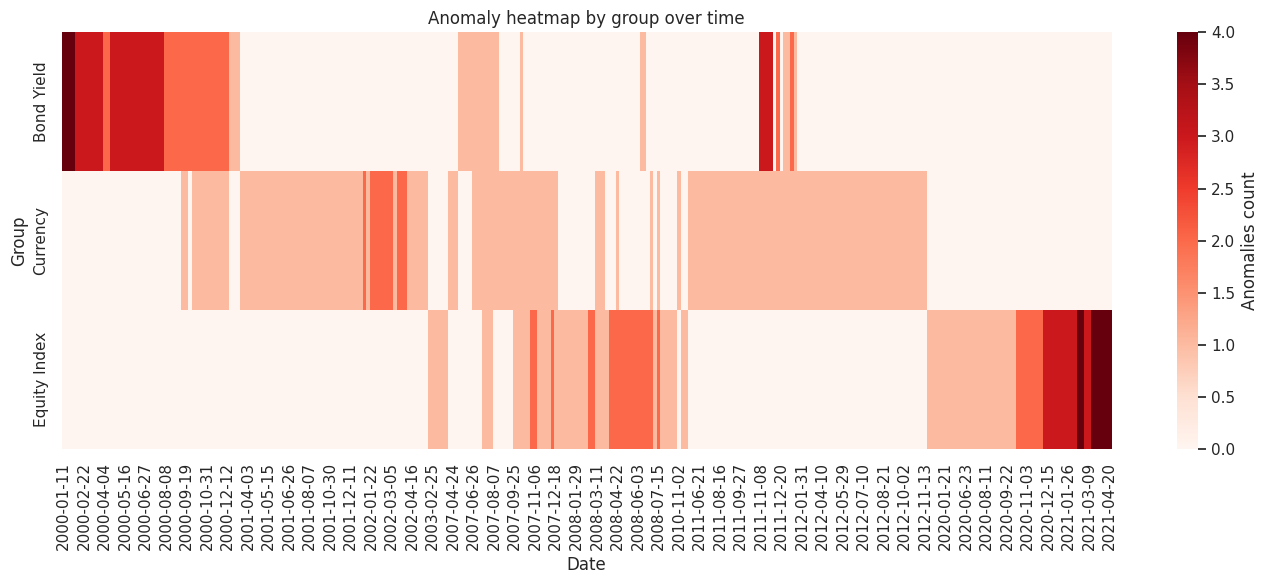

In [ ]:
# Download the file "anomaly_directions.csv" from your Colab session to your local machine
from google.colab import files
files.download("anomaly_directions.csv")

# Load the CSV file into a DataFrame
df_anomalies = pd.read_csv("anomaly_directions.csv")
print(df_anomalies.head())

# (Optional duplicate line) Load again, assigning to a different variable (can be removed)
anomaly_df = pd.read_csv("anomaly_directions.csv")

# Count how many anomalies occurred per day for each group (e.g., rates, equities, commodities)
group_day_counts = anomaly_df.groupby(["Date", "Group"]).size().unstack(fill_value=0)
# This creates a DataFrame where:
# - Rows are Dates
# - Columns are Groups
# - Values are the number of anomalies for each group on each date

# Import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size for the plot
plt.figure(figsize=(14, 6))

# Create a heatmap of anomalies per group over time
sns.heatmap(group_day_counts.T, cmap="Reds", cbar_kws={"label": "Anomalies count"})
# - .T transposes the DataFrame so Groups are on the y-axis and Dates on the x-axis
# - cmap="Reds" uses a red color scale
# - cbar_kws adds a colorbar with label

# Add title and axis labels
plt.title("Anomaly heatmap by group over time")
plt.xlabel("Date")
plt.ylabel("Group")

# Adjust layout for better spacing
plt.tight_layout()

# Show the heatmap
plt.show()

## Coping with Stationarity

Before applying any predictive model, we need our features to be **stationary**. This means their statistical properties (mean, variance, autocorrelation, etc.) should remain stable over time. Otherwise, models trained on past data could produce unreliable or misleading results.

In this notebook, we transform the features based on their economic nature:

- **Indices and currencies** (e.g., MSCI indices, commodities, FX rates) are strictly positive, so we apply **log-differences** to make them stationary.
- **Interest rates and bond yields** can be negative or near zero, so we apply **first differences**.
- The **Bloomberg Economic Surprise Index (ECSURPUS)** is left unchanged, as it is already approximately stationary.

> Only the **features** are transformed. The target variable `Y`, which indicates anomalies, remains unchanged.

Below, we define the relevant variable groups and apply the appropriate transformations to create a stationary dataset.


In [ ]:
# Make data stationary based on variable type
# So w define lists of variables by type
indices_currencies = [col for col in X_df.columns if col in [
    'XAUBGNL', 'BDIY', 'CRY', 'Cl1', 'DXY', 'EMUSTRUU', 'GBP', 'JPY', 'LF94TRUU',
    'LF98TRUU', 'LG30TRUU', 'LMBITR', 'LP01TREU', 'LUACTRUU', 'LUMSTRUU',
    'MXBR', 'MXCN', 'MXEU', 'MXIN', 'MXJP', 'MXRU', 'MXUS', 'VIX'
]]

interest_rates = [col for col in X_df.columns if col in [
    'EONIA', 'GTDEM10Y', 'GTDEM2Y', 'GTDEM30Y', 'GTGBP20Y', 'GTGBP2Y', 'GTGBP30Y',
    'GTITL10YR', 'GTITL2YR', 'GTITL30YR', 'GTJPY10YR', 'GTJPY2YR', 'GTJPY30YR',
    'US0001M', 'USGG3M', 'USGG2YR', 'GT10', 'USGG30YR'
]]

# Create a new dataframe for stationary data
stationary_df = pd.DataFrame(index=X_df.index[1:])

# Apply log-differences to indices and currencies (always positive)
for col in indices_currencies:
    if col in X_df.columns:
        stationary_df[col] = np.diff(np.log(X_df[col]))

# Apply first differences to interest rates (can be negative or very close to 0)
for col in interest_rates:
    if col in X_df.columns:
        stationary_df[col] = np.diff(X_df[col])

# Keep Bloomberg Economic US Surprise Index as is (already stationary)
if 'ECSURPUS' in X_df.columns:
    stationary_df['ECSURPUS'] = X_df['ECSURPUS'].values[1:]

# Adjust the response variable to match the new data length
if y is not None:
    y_stationary = y[1:]
else:
    y_stationary = None


## Data Preparation – Splitting and Standardization

In this step, we prepare the dataset for training and evaluation.

To begin, we **shuffle the data** to remove any temporal dependencies or autocorrelation that might bias the learning process. Then, we **split the data into three sets**:

- **Training set**: Contains only normal (non-anomalous) data and will be used to fit the model.
- **Cross-validation set**: A mix of normal and anomalous data, used to tune model thresholds and evaluate performance during training.
- **Test set**: Also a mix of normal and anomalous data, used for final model evaluation.

The proportions are as follows:
- 80% of normal samples go to the training set
- 10% of normal samples + 50% of anomalies go to the cross-validation set
- The remaining 10% of normal samples + the remaining 50% of anomalies go to the test set

Finally, we **standardize** the features using `StandardScaler` to ensure that all variables contribute equally to the model, avoiding scale-related biases.

This approach enables us to train the model using only normal data (unsupervised) and then assess its performance in identifying anomalies on separate, balanced validation and test sets.


In [ ]:
# Step 1: shuffle and split data into training, validation, and test sets
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

# Set visualization style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]

# Convert to numpy arrays for easier manipulation
X = stationary_df.values
y = y_stationary

# Step 1: Creating training/cross-validation/test set with reshuffling

# Reshuffle the data (this will break down autocorrelation)
X_shuffled, y_shuffled = shuffle(X, y, random_state=42)

# Separate normal and anomalous examples
X_normal = X_shuffled[y_shuffled == 0]
X_anomaly = X_shuffled[y_shuffled == 1]

# Calculate sizes for each set
n_normal = X_normal.shape[0]
n_anomaly = X_anomaly.shape[0]

# Training set: 80% of normal examples
train_size = int(0.8 * n_normal)
X_train = X_normal[:train_size]

# Cross-validation set: 10% of normal examples and 50% of anomalies
cv_normal_size = int(0.1 * n_normal)
cv_anomaly_size = int(0.5 * n_anomaly)
X_cv_normal = X_normal[train_size:train_size + cv_normal_size]
X_cv_anomaly = X_anomaly[:cv_anomaly_size]
X_cross_val = np.vstack((X_cv_normal, X_cv_anomaly))
y_cross_val = np.hstack((np.zeros(cv_normal_size), np.ones(cv_anomaly_size)))

# Test set: 10% of normal examples and 50% of anomalies
X_test_normal = X_normal[train_size + cv_normal_size:]
X_test_anomaly = X_anomaly[cv_anomaly_size:]
X_test = np.vstack((X_test_normal, X_test_anomaly))
y_test = np.hstack((np.zeros(len(X_test_normal)), np.ones(len(X_test_anomaly))))

# We'll standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_cross_val = scaler.transform(X_cross_val)
X_test = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]} (all normal)")
print(f"Cross-validation set size: {X_cross_val.shape[0]} ({cv_normal_size} normal, {cv_anomaly_size} anomalies)")
print(f"Test set size: {X_test.shape[0]} ({len(X_test_normal)} normal, {len(X_test_anomaly)} anomalies)")


Training set size: 698 (all normal)
Cross-validation set size: 205 (87 normal, 118 anomalies)
Test set size: 207 (88 normal, 119 anomalies)


## Comparing Anomaly Detection Models

In this section, we explore and compare a variety of anomaly detection approaches — ranging from classical statistical models to advanced deep learning techniques.

All models are evaluated on the same financial dataset using a consistent set of performance metrics: **Precision**, **Recall**, **F1 Score**, **Confusion Matrix**, and **ROC Curve**. We also visualize the results using **UMAP 3D**, to better understand how different models separate normal and anomalous data in feature space.

We organize the models into four main categories:

- **Baseline model**: the **Multivariate Gaussian (MVG)** model trained only on normal data, which serves as our reference point.
- **Supervised models**: which rely on labeled data.
- **Unsupervised models**: which detect anomalies without labeled supervision.
- **Deep learning**: **Autoencoders and Neural Networks** trained on normal data, using reconstruction error to identify deviations.
-**Ensemble models**: that mix different methods.

The objective is not only to assess predictive performance, but also to reflect on key methodological trade-offs — such as the balance between **model complexity and interpretability**, the **need for labeled data**, and the **flexibility** of each method in adapting to complex financial data structures.


In [ ]:
# Functions and utilities for comparison of supervised and unsupervised Anomaly Detection methods

from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import OneClassSVM, SVC
from sklearn.neighbors import LocalOutlierFactor

# Set visualization style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]

# We already have X_train, X_cross_val, y_cross_val, X_test, y_test from previous code cells
# We'll standardize the data for better performance with many algorithms
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_cv_scaled = scaler.transform(X_cross_val)
X_test_scaled = scaler.transform(X_test)

# Function to evaluate and visualize model performance
def evaluate_model(y_true, y_pred, y_score, model_name):
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"\n{model_name} Performance:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Anomaly'],
                yticklabels=['Normal', 'Anomaly'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.show()

    # ROC Curve
    if y_score is not None:  # Some models don't provide probability scores
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()

    return precision, recall, f1

# Function to visualize results in PCA space
def visualize_pca(X, y_true, y_pred, model_name):
    # Apply PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Create a DataFrame for plotting
    pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    pca_df['Actual'] = y_true
    pca_df['Predicted'] = y_pred

    # Create classification categories
    pca_df['Category'] = 'Unknown'
    pca_df.loc[(y_true == 0) & (y_pred == 0), 'Category'] = 'True Negative'
    pca_df.loc[(y_true == 0) & (y_pred == 1), 'Category'] = 'False Positive'
    pca_df.loc[(y_true == 1) & (y_pred == 0), 'Category'] = 'False Negative'
    pca_df.loc[(y_true == 1) & (y_pred == 1), 'Category'] = 'True Positive'

    # Calculate explained variance
    explained_variance = pca.explained_variance_ratio_
    total_variance = sum(explained_variance)

    # Plot
    plt.figure(figsize=(12, 8))

    # Define colors and sizes
    colors = {'True Negative': 'gray', 'True Positive': 'black',
              'False Positive': 'red', 'False Negative': 'blue'}
    alphas = {'True Negative': 0.3, 'True Positive': 0.5,
              'False Positive': 0.8, 'False Negative': 0.8}
    sizes = {'True Negative': 30, 'True Positive': 40,
             'False Positive': 80, 'False Negative': 80}

    # Plot each category
    for category, group in pca_df.groupby('Category'):
        plt.scatter(group['PC1'], group['PC2'],
                    color=colors[category],
                    alpha=alphas[category],
                    s=sizes[category],
                    label=f"{category} ({len(group)})")

    plt.title(f'PCA projection - {model_name}\nExplained variance: {total_variance:.2%}', fontsize=16)
    plt.xlabel(f'PC1 ({explained_variance[0]:.2%})', fontsize=14)
    plt.ylabel(f'PC2 ({explained_variance[1]:.2%})', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

# Store results for comparison
results = []


## Multivariate Gaussian Anomaly Detection – Baseline Model

In this section, we implement a basic **Multivariate Gaussian (MVG) anomaly detector** to serve as a **baseline model** for identifying anomalies in financial data.

The procedure follows a standard unsupervised approach with supervised threshold tuning:

1. **Estimate the distribution** of normal (non-anomalous) data by calculating the mean vector and covariance matrix.
2. **Score all data points** using the multivariate Gaussian probability density function (PDF).
3. **Tune the detection threshold (ε)** using the labeled cross-validation set to optimize the F1 score.
4. **Evaluate performance** on a held-out test set using precision, recall, F1 score, and confusion matrix.
5. **Visualize the results** using selected features to better understand classification outcomes in feature space.

Although this model is relatively simple, it provides a strong foundation to benchmark against **more advanced models** that we will explore later, such as isolation-based or density-based detectors. Keeping this MVG approach as a baseline helps us assess whether more complex models offer real performance gains.


In [ ]:
# Training the model (estimating parameters of multivariate Gaussian)

# Calculate mean vector
mu = np.mean(X_train, axis=0)

# Calculate covariance matrix
sigma = np.cov(X_train, rowvar=False)

print(f"Mean vector shape: {mu.shape}")
print(f"Covariance matrix shape: {sigma.shape}")


Mean vector shape: (42,)
Covariance matrix shape: (42, 42)


Best F1 score on CV set: 0.7616
Best Epsilon: 8.09971191e-14
Corresponding Precision: 0.6250
Corresponding Recall: 0.9746


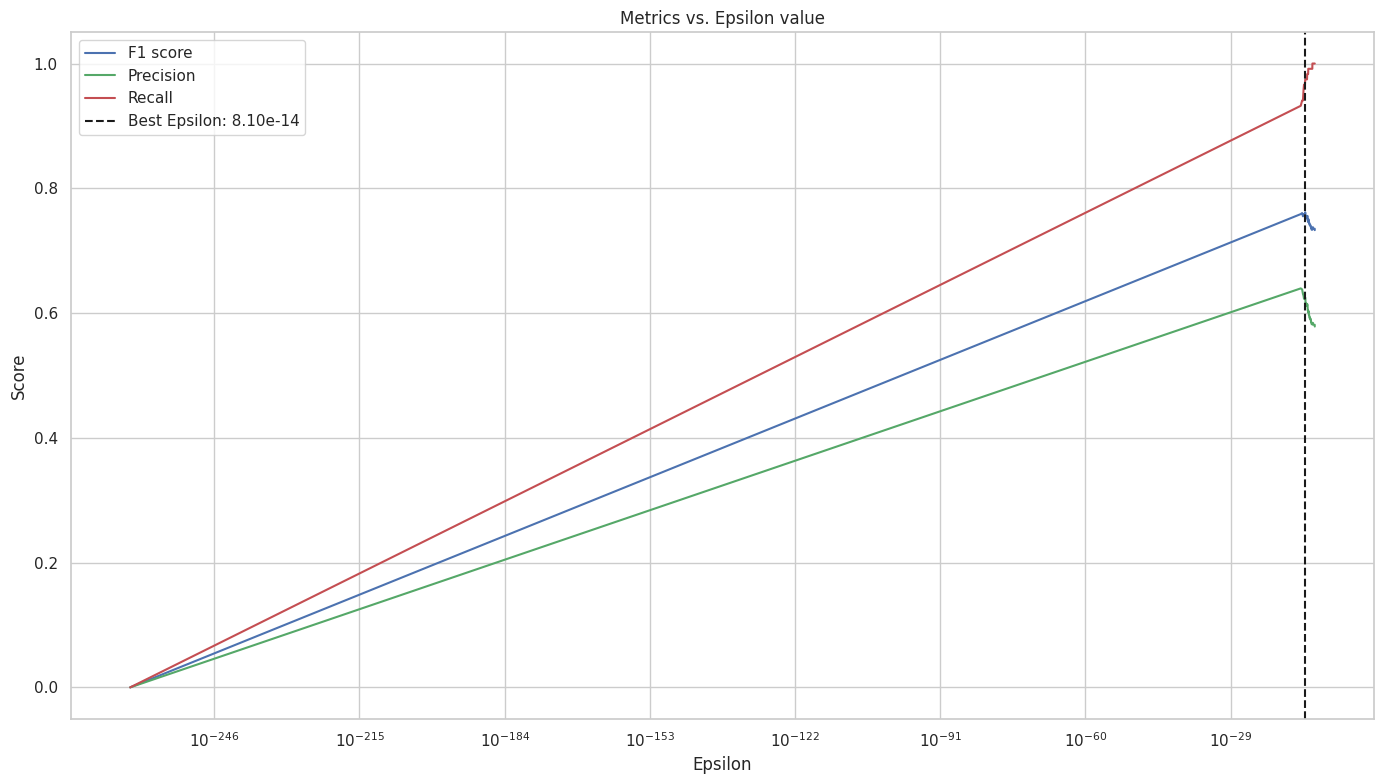

In [ ]:
# Fine tuning the hyperparameter, the threshold ϵ

# Function to calculate multivariate Gaussian PDF
def multivariate_gaussian_pdf(X, mu, sigma):
    """Calculate the multivariate Gaussian probability density function"""
    n = mu.shape[0]

    # Handle potential numerical issues with the covariance matrix
    # Add a small regularization term to ensure positive definiteness
    sigma_reg = sigma + np.eye(n) * 1e-8

    # Calculate determinant and inverse
    try:
        det = np.linalg.det(sigma_reg)
        inv = np.linalg.inv(sigma_reg)
    except np.linalg.LinAlgError:
        # If still having issues, use pseudo-inverse
        print("Warning: Using pseudo-inverse for covariance matrix")
        det = max(np.linalg.det(sigma_reg), 1e-10)
        inv = np.linalg.pinv(sigma_reg)

    # Calculate PDF for each example
    p = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        x_mu = X[i] - mu
        p[i] = (1.0 / (np.power(2 * np.pi, n/2) * np.sqrt(det))) * \
               np.exp(-0.5 * x_mu.dot(inv).dot(x_mu))

    return p

# Compute the probability density function for the cross-validation set
p_cv = multivariate_gaussian_pdf(X_cross_val, mu, sigma)

# Find the range of epsilon values to search
min_epsilon = np.min(p_cv)
max_epsilon = np.max(p_cv)
step_size = (max_epsilon - min_epsilon) / 1000

# Find the best epsilon using F1 score
best_epsilon = 0
best_f1 = 0
best_precision = 0
best_recall = 0

epsilon_values = np.arange(min_epsilon, max_epsilon, step_size)
f1_scores = []
precisions = []
recalls = []

for epsilon in epsilon_values:
    predictions = (p_cv < epsilon).astype(int)

    # Calculate metrics
    precision = precision_score(y_cross_val, predictions, zero_division=0)
    recall = recall_score(y_cross_val, predictions, zero_division=0)

    # Calculate F1 score
    if precision + recall > 0:  # Avoid division by zero
        f1 = 2 * precision * recall / (precision + recall)
    else:
        f1 = 0

    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    if f1 > best_f1:
        best_f1 = f1
        best_epsilon = epsilon
        best_precision = precision
        best_recall = recall

print(f"Best F1 score on CV set: {best_f1:.4f}")
print(f"Best Epsilon: {best_epsilon:.8e}")
print(f"Corresponding Precision: {best_precision:.4f}")
print(f"Corresponding Recall: {best_recall:.4f}")

# Plot F1 score, precision, and recall vs epsilon
plt.figure(figsize=(14, 8))
plt.plot(epsilon_values, f1_scores, 'b-', label='F1 score')
plt.plot(epsilon_values, precisions, 'g-', label='Precision')
plt.plot(epsilon_values, recalls, 'r-', label='Recall')
plt.axvline(x=best_epsilon, color='k', linestyle='--', label=f'Best Epsilon: {best_epsilon:.2e}')
plt.xlabel('Epsilon')
plt.ylabel('Score')
plt.title('Metrics vs. Epsilon value')
plt.legend()
plt.xscale('log')  # Log scale for better visualization
plt.grid(True)
plt.tight_layout()
plt.show()



Test set performance:
Precision: 0.6031
Recall: 0.9832
F1 Score: 0.7476

Confusion Matrix:
True Negatives: 11
False Positives: 77
False Negatives: 2
True Positives: 117


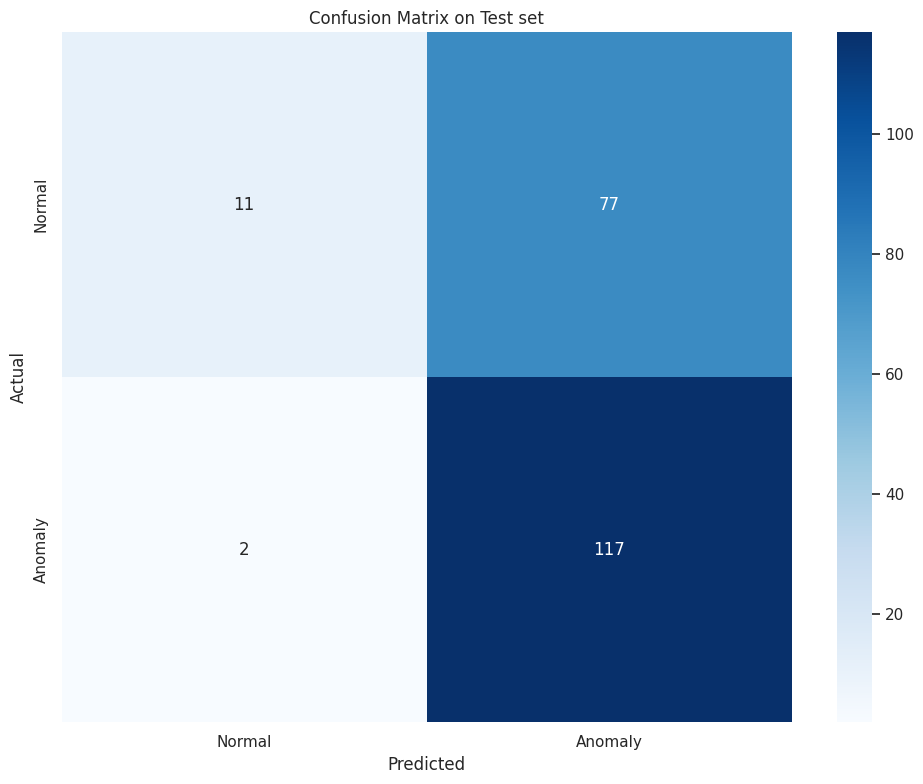

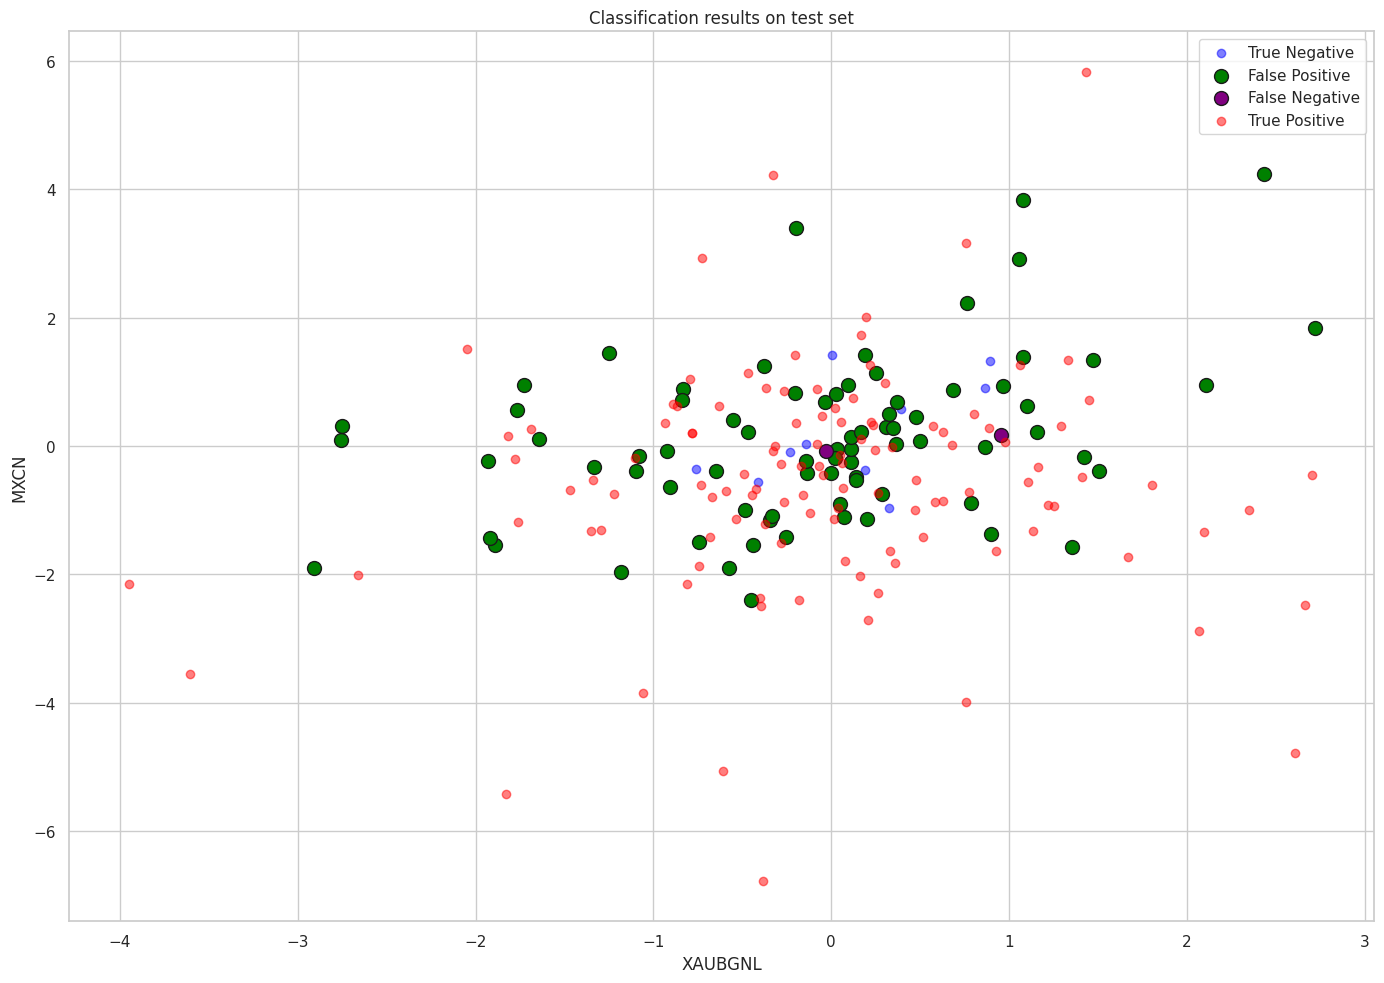

In [ ]:
from sklearn.metrics import confusion_matrix

# Testing the model

# Compute the probability density function for the test set
p_test = multivariate_gaussian_pdf(X_test, mu, sigma)

# Make predictions using the best epsilon
predictions = (p_test < best_epsilon).astype(int)

# Calculate metrics
MVG_precision = precision_score(y_test, predictions, zero_division=0)
MVG_recall = recall_score(y_test, predictions, zero_division=0)
MVG_f1 = f1_score(y_test, predictions, zero_division=0)

print("\nTest set performance:")
print(f"Precision: {MVG_precision:.4f}")
print(f"Recall: {MVG_recall:.4f}")
print(f"F1 Score: {MVG_f1:.4f}")

# Create confusion matrix
cm = confusion_matrix(y_test, predictions)
tn, fp, fn, tp = cm.ravel()

print("\nConfusion Matrix:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test set')
plt.tight_layout()
plt.show()


# Visualize examples of correctly and incorrectly classified points
# Select two features for visualization
if X_test.shape[1] >= 2:
    # Choose two features (columns) for visualization
    feature1_idx = 22  # First feature
    feature2_idx = 15  # Second feature

    # Get feature names
    feature1_name = stationary_df.columns[feature1_idx]
    feature2_name = stationary_df.columns[feature2_idx]

    plt.figure(figsize=(14, 10))

    # True negatives (correctly classified normal points)
    plt.scatter(X_test[(y_test == 0) & (predictions == 0), feature1_idx],
                X_test[(y_test == 0) & (predictions == 0), feature2_idx],
                c='blue', marker='o', alpha=0.5, label='True Negative')

    # False positives (normal points classified as anomalies)
    plt.scatter(X_test[(y_test == 0) & (predictions == 1), feature1_idx],
                X_test[(y_test == 0) & (predictions == 1), feature2_idx],
                c='green', marker='o', s=100, edgecolors='k', label='False Positive')

    # False negatives (anomalies classified as normal)
    plt.scatter(X_test[(y_test == 1) & (predictions == 0), feature1_idx],
                X_test[(y_test == 1) & (predictions == 0), feature2_idx],
                c='purple', marker='o', s=100, edgecolors='k', label='False Negative')

    # True positives (correctly classified anomalies)
    plt.scatter(X_test[(y_test == 1) & (predictions == 1), feature1_idx],
                X_test[(y_test == 1) & (predictions == 1), feature2_idx],
                c='red', marker='o', alpha=0.5, label='True Positive')

    plt.xlabel(feature1_name)
    plt.ylabel(feature2_name)
    plt.title('Classification results on test set')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Global Visualization via PCA

To gain an overall understanding of the model’s performance across the entire feature space, we apply **Principal Component Analysis (PCA)** to the test set.

PCA reduces the high-dimensional data into two principal components that capture the greatest variance in the dataset. This enables a **compact 2D visualization** of the classification results, making it easier to analyze how well the model distinguishes between normal and anomalous points.

Each data point is categorized as:
- **True Positive (TP)** – correctly identified anomaly  
- **False Positive (FP)** – normal point incorrectly flagged as anomaly  
- **False Negative (FN)** – missed anomaly  
- **True Negative (TN)** – correctly ignored normal point  

This plot helps us observe whether errors (FP/FN) are **localized in specific regions** or **scattered across the PCA space**. Interestingly, in this case, anomalies do **not cluster at the edges**, as one might expect from simpler models. Instead, they are **spread across the projection**, indicating that:

- Anomalous behavior may not align with the top directions of variance captured by PCA
- The feature space and market dynamics are complex
- **Linear projection methods like PCA may not fully capture the structure of anomalies**

This highlights a known limitation of **density-based anomaly detectors** when combined with **linear dimensionality reduction**: anomalies can exist in high-density regions and require **more expressive or nonlinear models** to be effectively detected.

For these reasons, we will next use **UMAP in 3D** to obtain a more expressive and nonlinear visualization of the data.  
Unlike PCA, UMAP captures local and global structures in a nonlinear way, which can help reveal hidden patterns and separate anomalies more clearly in complex datasets.


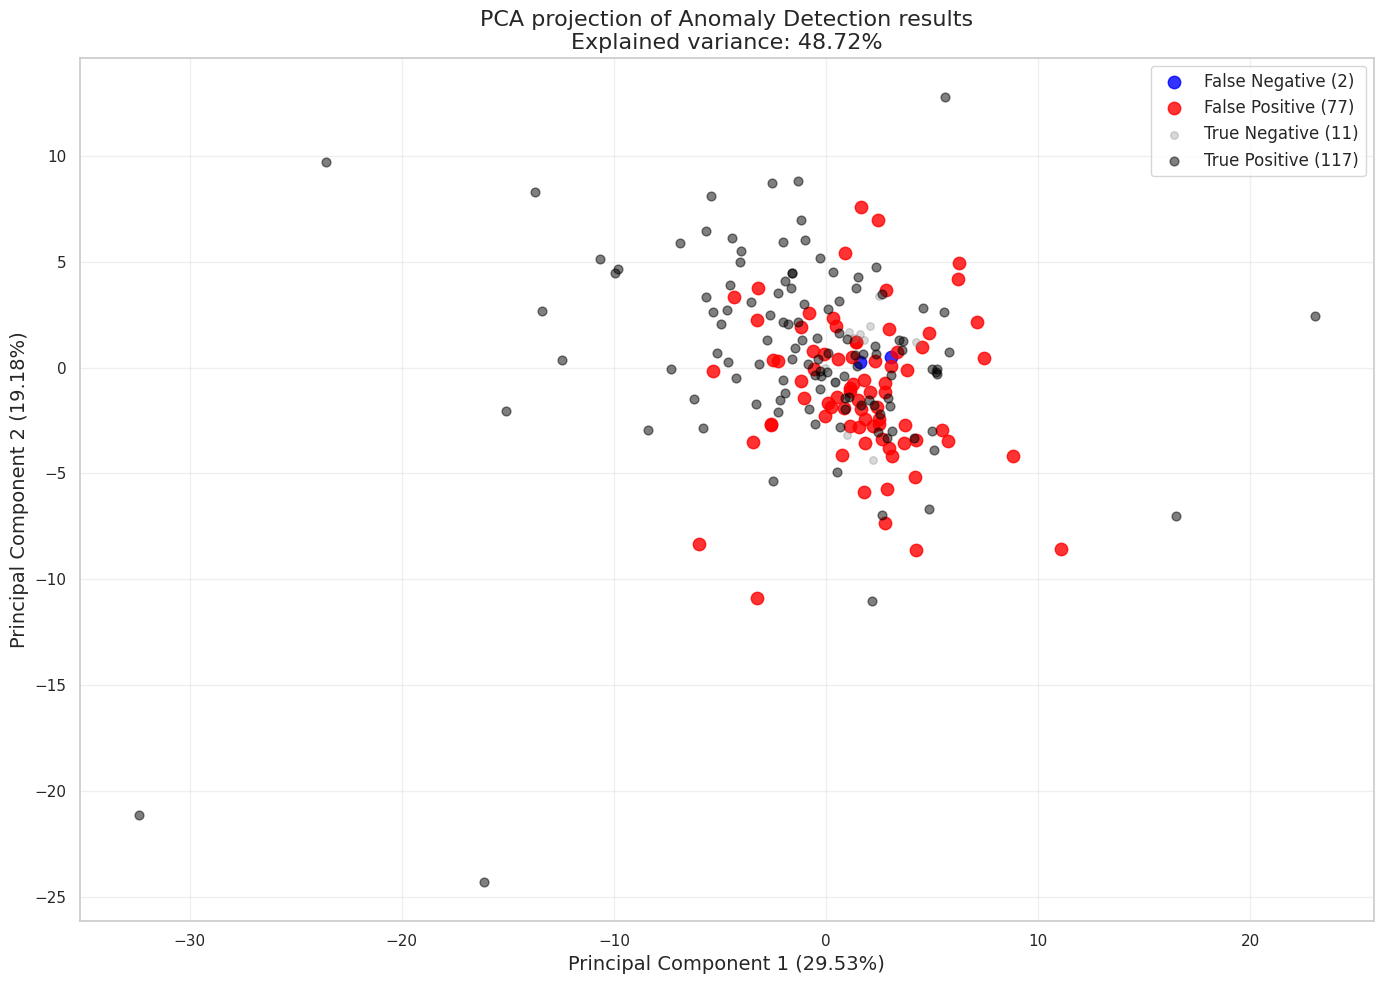

Variance explained by first two principal components: 48.72%


In [ ]:
# PCA visualization of anomalies
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

# Create a DataFrame for easier plotting
pca_df = pd.DataFrame(X_test_pca, columns=['PC1', 'PC2'])
pca_df['Actual'] = y_test
pca_df['Predicted'] = predictions

# Create classification categories
pca_df['Category'] = 'Unknown'
pca_df.loc[(y_test == 0) & (predictions == 0), 'Category'] = 'True Negative'
pca_df.loc[(y_test == 0) & (predictions == 1), 'Category'] = 'False Positive'
pca_df.loc[(y_test == 1) & (predictions == 0), 'Category'] = 'False Negative'
pca_df.loc[(y_test == 1) & (predictions == 1), 'Category'] = 'True Positive'

# Calculate explained variance (just to know...)
explained_variance = pca.explained_variance_ratio_
total_variance = sum(explained_variance)

# Plot the PCA projection
plt.figure(figsize=(14, 10))

# Define colors and markers
colors = {'True Negative': 'gray', 'True Positive': 'black',
          'False Positive': 'red', 'False Negative': 'blue'}

# Use same marker for all to simplify
markers = {'True Negative': 'o', 'True Positive': 'o',
           'False Positive': 'o', 'False Negative': 'o'}

# Make misclassified points very visible
alphas = {'True Negative': 0.3, 'True Positive': 0.5,
          'False Positive': 0.8, 'False Negative': 0.8}

sizes = {'True Negative': 30, 'True Positive': 40,
         'False Positive': 80, 'False Negative': 80}

# Plot each category
for category, group in pca_df.groupby('Category'):
    plt.scatter(group['PC1'], group['PC2'],
                color=colors[category],
                marker=markers[category],
                alpha=alphas[category],
                s=sizes[category],
                label=f"{category} ({len(group)})")

# Title and labels
plt.title(f'PCA projection of Anomaly Detection results\nExplained variance: {total_variance:.2%}', fontsize=16)
plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.2%})', fontsize=14)
plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.2%})', fontsize=14)

# Grid and legend
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

# Print variance explained
print(f"Variance explained by first two principal components: {total_variance:.2%}")


## Supervised Models

In this section, we train **supervised anomaly detection models** using the labels that indicate whether each observation is normal or anomalous.

To do this, we need a dataset that includes both types of observations. Since our original training set was intentionally composed only of normal data, we now combine it with the **cross-validation set**, which contains both normal and anomalous samples. This combined set serves as the **labeled training data** for supervised algorithms.

This approach enables models such as **Random Forest** to learn how to distinguish between normal and anomalous patterns, based on real labeled examples.

Note: we are not using the validation set for hyperparameter tuning in this context. Its role is purely to expand the amount of labeled data available for training supervised models.


The first model we test is the **Random Forest**, a widely used supervised learning algorithm.  
It is a natural starting point because it is relatively simple to implement and is **easily interpretable** compared to more complex models.  

SUPERVISED ANOMALY DETECTION METHODS

Training Random Forest classifier...

Random Forest (Supervised) Performance:
Precision: 1.0000
Recall: 0.0252
F1 Score: 0.0492


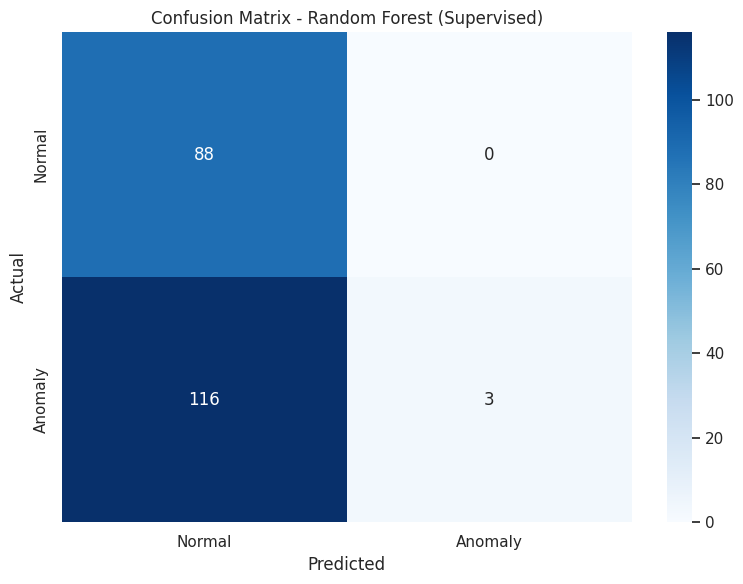

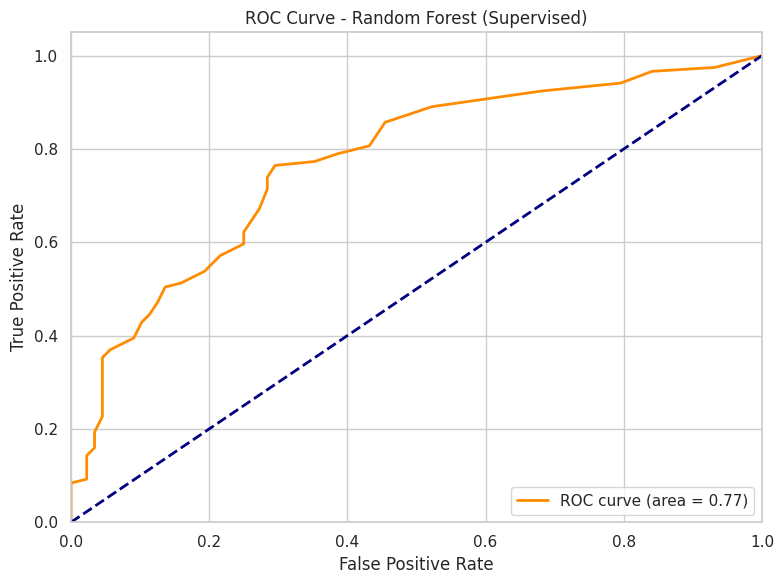

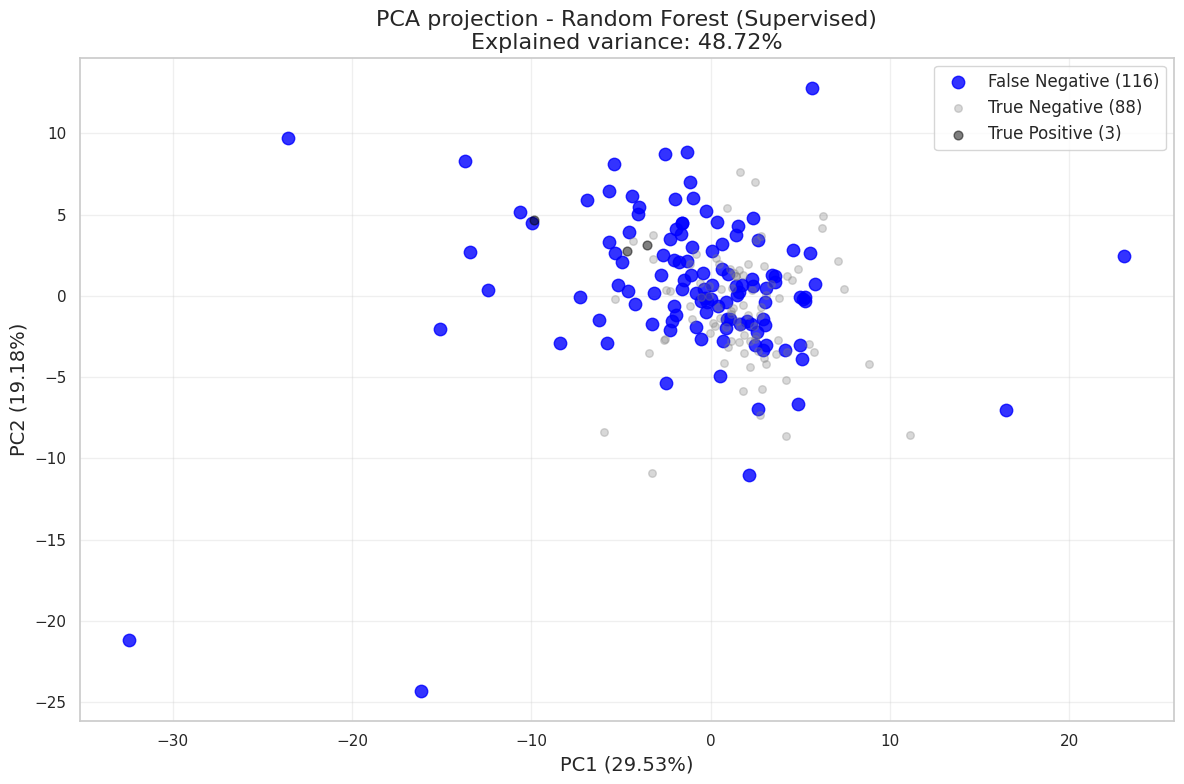

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
# SUPERVISED APPROACHES

print("=" * 50)
print("SUPERVISED ANOMALY DETECTION METHODS")
print("=" * 50)

# Random Forest Classifier
print("\nTraining Random Forest classifier...")
# For supervised methods, we need to combine training and cross-validation sets in order to have some anomalies to train with
X_train_cv = np.vstack((X_train_scaled, X_cv_scaled))
y_train_cv = np.hstack((np.zeros(len(X_train_scaled)), y_cross_val))

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_cv, y_train_cv)  # Train on combined data

# Predict on test set
rf_pred = rf_model.predict(X_test_scaled)
rf_score = rf_model.predict_proba(X_test_scaled)[:, 1]  # Probability of class 1 (anomaly)

# Evaluate
rf_metrics = evaluate_model(y_test, rf_pred, rf_score, "Random Forest (Supervised)")
visualize_pca(X_test_scaled, y_test, rf_pred, "Random Forest (Supervised)")
results.append(("Random Forest (Supervised)", *rf_metrics))


Since the initial performance of the Random Forest model was unsatisfactory, we applied **hyperparameter optimization** to try to improve its results.  
As shown in the updated evaluation metrics, this tuning process led to a **noticeable improvement** in the model's ability to detect anomalies, yet not satisfactory enough.


[I 2025-05-28 07:58:54,865] A new study created in memory with name: no-name-4b5794c0-be8b-4de8-affd-73f605dfe3d6


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-28 07:58:55,985] Trial 0 finished with value: 0.9694323144104804 and parameters: {'n_estimators': 126, 'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.9694323144104804.
[I 2025-05-28 07:58:58,412] Trial 1 finished with value: 0.8785046728971962 and parameters: {'n_estimators': 458, 'max_depth': 6, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.9694323144104804.
[I 2025-05-28 07:59:02,264] Trial 2 finished with value: 0.979253112033195 and parameters: {'n_estimators': 430, 'max_depth': 18, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': 'log2', 'bootstrap': False}. Best is trial 2 with value: 0.979253112033195.
[I 2025-05-28 07:59:15,888] Trial 3 finished with value: 0.979253112033195 and parameters: {'n_estimators': 492, 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 10, 'max_featu

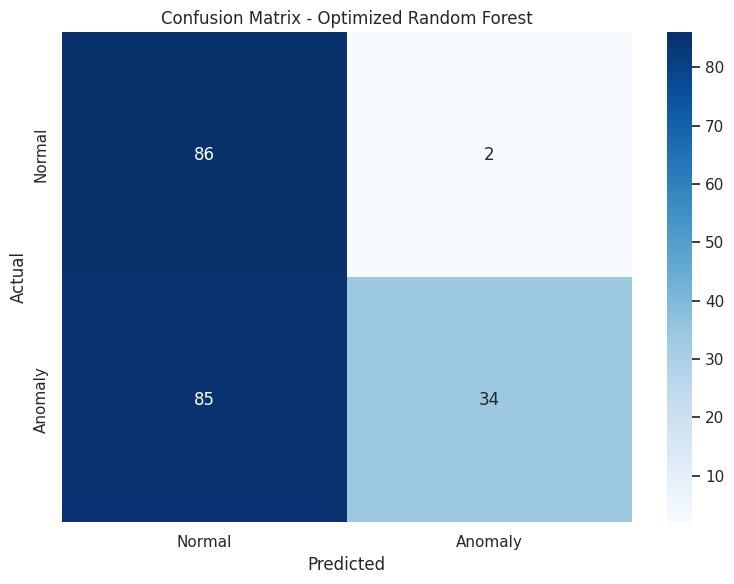

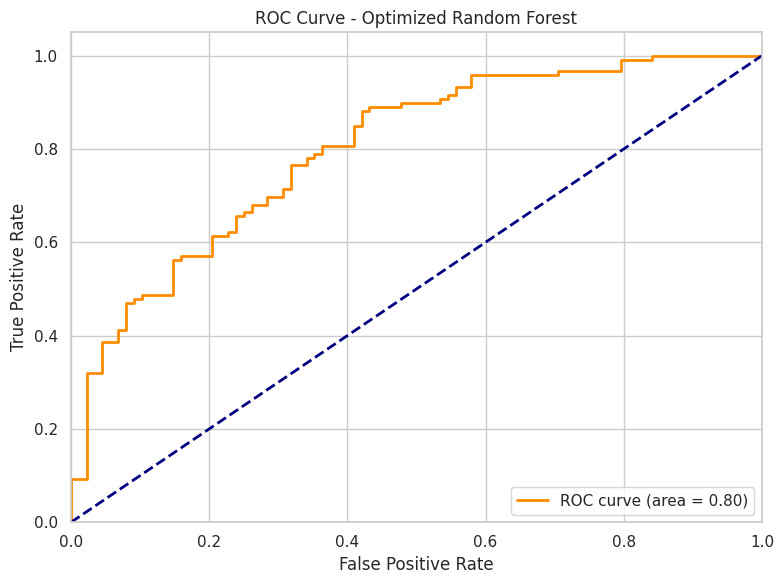

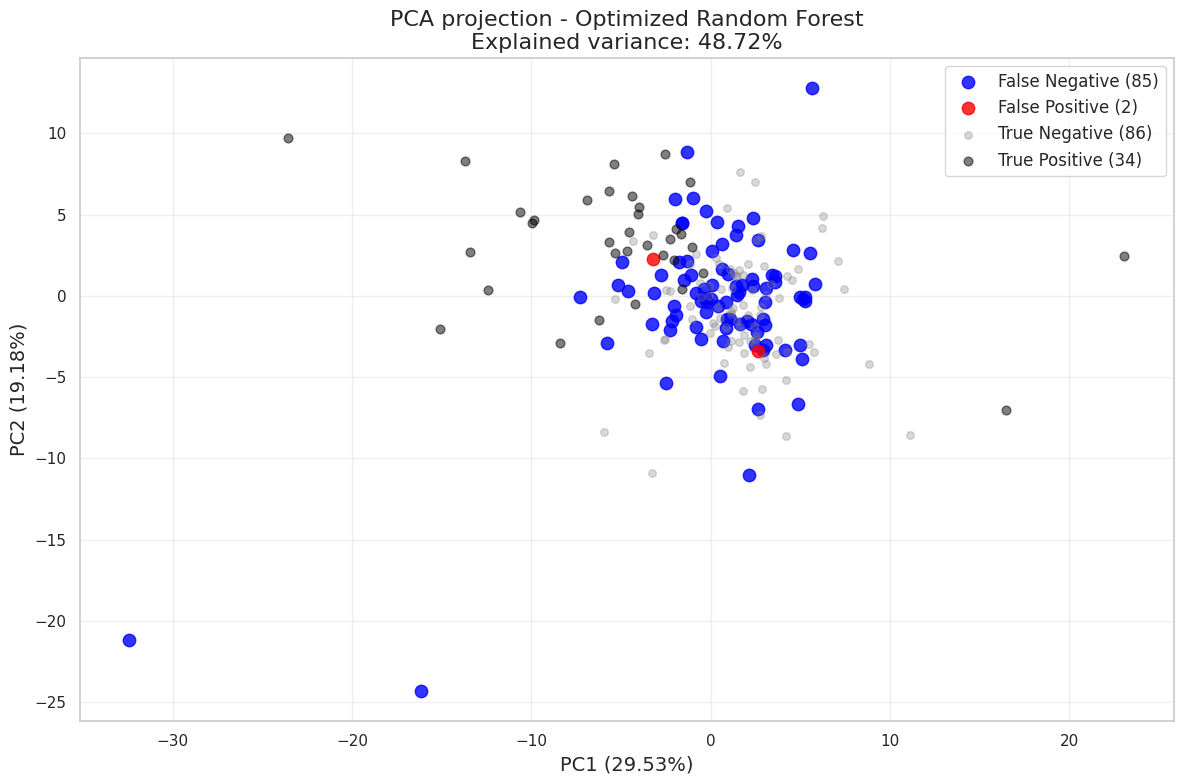

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


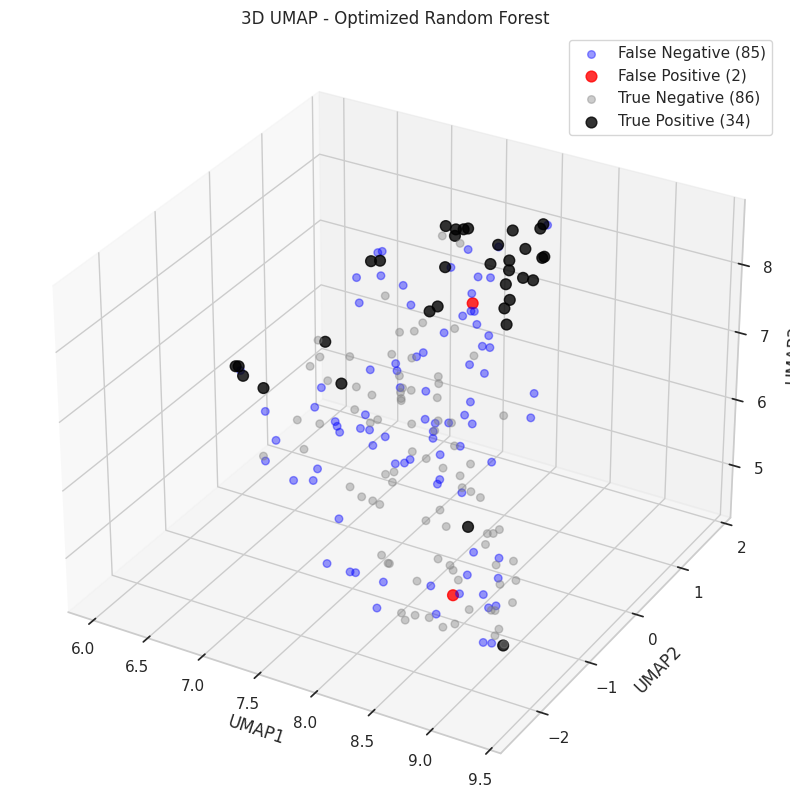

In [ ]:
import optuna
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score, precision_score, recall_score
from optuna import Trial, visualization
from umap import UMAP
from mpl_toolkits.mplot3d import Axes3D

# Define the optimization function for Random Forest

def objective_rf(trial: Trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    # Create the model with the suggested parameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=42,
        class_weight="balanced"
    )

    # Train on the combined training and cross-validation sets
    model.fit(X_train_cv, y_train_cv)

    # Cross-validate using the held-out test set
    y_pred = model.predict(X_cross_val)
    y_score = model.predict_proba(X_cross_val)[:, 1]

    # Use F1 score as the optimization metric
    f1 = f1_score(y_cross_val, y_pred, zero_division=0)
    return f1

# Run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective_rf, n_trials=50, show_progress_bar=True)

# Display the best hyperparameters
print("\nBest hyperparameters:")
print(study.best_params)

# Retrain the model with the best hyperparameters
best_rf = RandomForestClassifier(**study.best_params, random_state=42, class_weight="balanced")
best_rf.fit(X_train_cv, y_train_cv)

# Final evaluation on the test set
rf_pred_final = best_rf.predict(X_test_scaled)
rf_score_final = best_rf.predict_proba(X_test_scaled)[:, 1]

# Evaluate and visualize
rf_metrics_final = evaluate_model(y_test, rf_pred_final, rf_score_final, "Optimized Random Forest")
visualize_pca(X_test_scaled, y_test, rf_pred_final, "Optimized Random Forest")
results.append(("Optimized Random Forest", *rf_metrics_final))

# 3D UMAP Visualization Function
def visualize_umap_3d(X, y_true, y_pred, model_name):
    # Apply UMAP
    reducer = UMAP(n_components=3, random_state=42)
    X_umap = reducer.fit_transform(X)

    # Create classification categories
    categories = np.array(["True Negative" if (yt == 0 and yp == 0) else
                           "True Positive" if (yt == 1 and yp == 1) else
                           "False Positive" if (yt == 0 and yp == 1) else
                           "False Negative"
                           for yt, yp in zip(y_true, y_pred)])

    # Color map for categories
    colors = {
        "True Negative": "gray",
        "True Positive": "black",
        "False Positive": "red",
        "False Negative": "blue"
    }

    # Plot
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    for category in np.unique(categories):
        mask = categories == category
        ax.scatter(
            X_umap[mask, 0],
            X_umap[mask, 1],
            X_umap[mask, 2],
            color=colors[category],
            alpha=0.8 if 'Positive' in category else 0.4,
            s=60 if 'Positive' in category else 30,
            label=f"{category} ({np.sum(mask)})"
        )
    ax.set_title(f"3D UMAP - {model_name}")
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")
    ax.set_zlabel("UMAP3")
    ax.legend()
    plt.show()

# Visualize the optimized RF on 3D UMAP
visualize_umap_3d(X_test_scaled, y_test, rf_pred_final, "Optimized Random Forest")



## XGBoost

**XGBoost** (Extreme Gradient Boosting) is a supervised machine learning algorithm based on gradient boosting.  
It builds an ensemble of decision trees sequentially, where each new tree focuses on correcting the errors made by the previous ones.

XGBoost is known for its high performance, speed, and ability to handle overfitting through regularization.  
It works well for both classification and regression tasks and is widely used in data science competitions.


In [ ]:
!pip install xgboost umap-learn

The results obtained with **XGBoost** are quite good, showing great performance in terms of precision, recall, and F1 score.  
This improvement is likely due to the algorithm’s ability to model complex, nonlinear relationships and its robustness to noise and irrelevant features.

Although **XGBoost is less interpretable** than simpler models like Random Forest, its predictive power makes it a valuable tool for anomaly detection in high-dimensional financial data.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:35:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- Threshold = 0.5 ---
Precision: 0.7538
Recall:    0.8235
F1 Score:  0.7871
ROC AUC:   0.7844


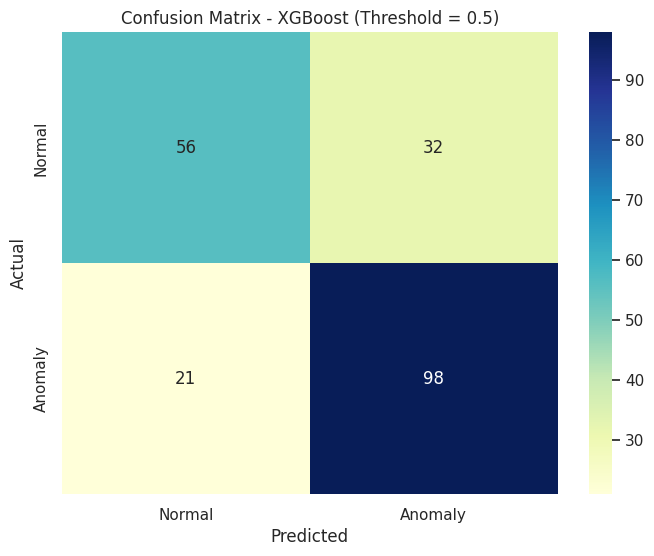


--- Optimal Threshold from ROC: 0.5835 ---
Precision: 0.7661
Recall:    0.7983
F1 Score:  0.7819


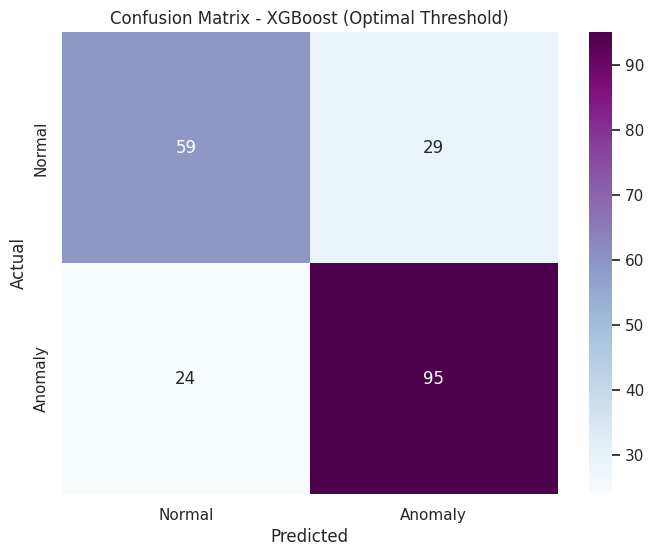

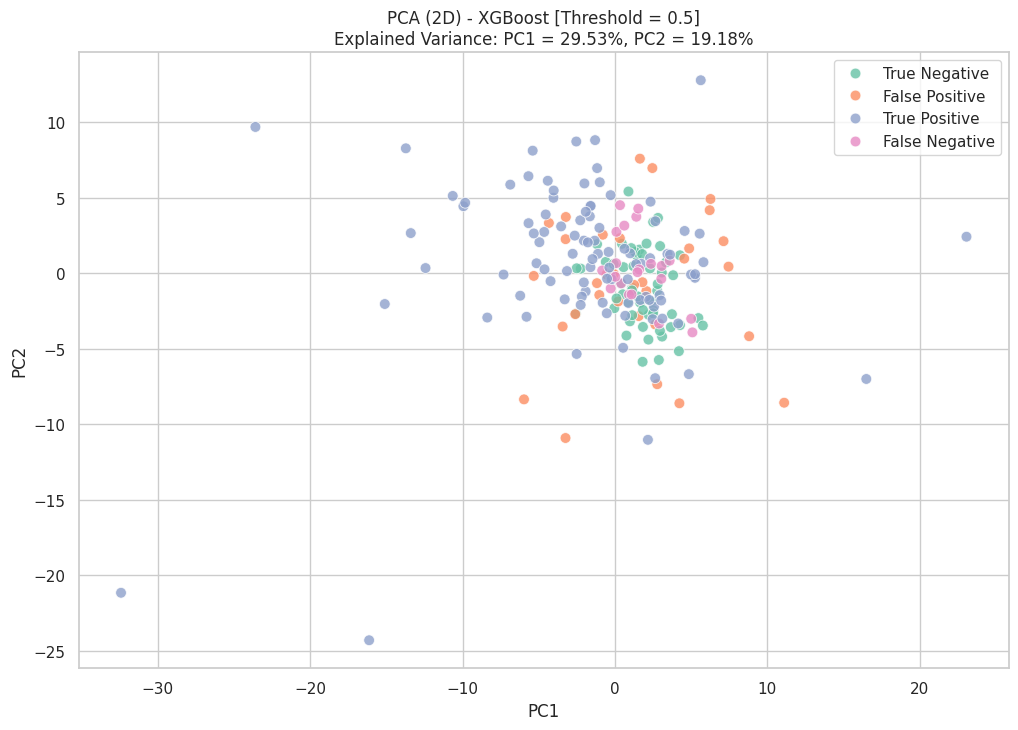

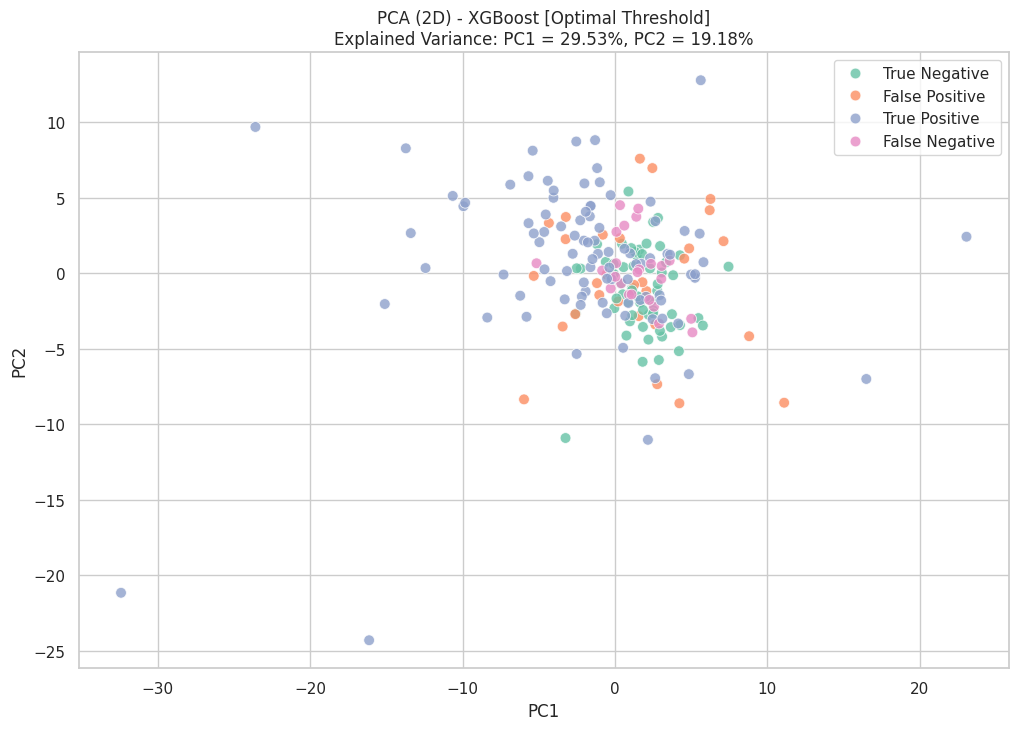

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


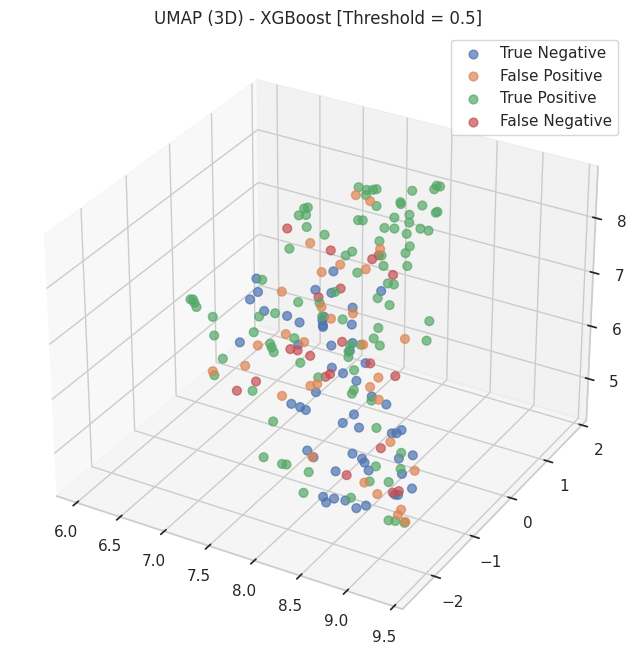

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


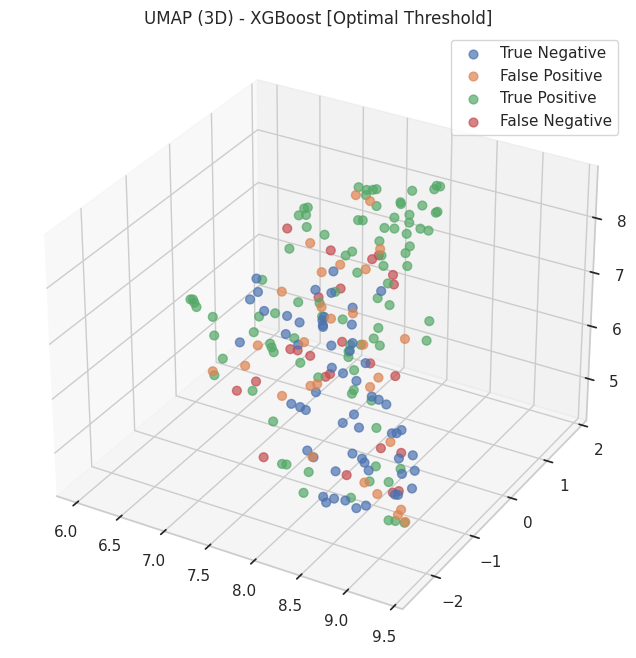

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
import umap.umap_ as umap
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Train XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# Fit on normal data first, then retrain with actual labeled data
xgb_clf.fit(X_train_scaled, np.zeros(X_train_scaled.shape[0]))
xgb_clf.fit(X_cross_val, y_cross_val)

# Predict probabilities
y_scores = xgb_clf.predict_proba(X_test_scaled)[:, 1]

# ───────────────────────────────────────────────
# 1. Threshold = 0.5
y_pred_05 = (y_scores > 0.5).astype(int)
print("\n--- Threshold = 0.5 ---")
precision = precision_score(y_test, y_pred_05, zero_division=0)
recall = recall_score(y_test, y_pred_05, zero_division=0)
f1 = f1_score(y_test, y_pred_05, zero_division=0)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_05)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix - XGBoost (Threshold = 0.5)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ───────────────────────────────────────────────
# 2. Threshold = optimal (Youden’s J)
youden_j = tpr - fpr
best_threshold = thresholds[np.argmax(youden_j)]
print(f"\n--- Optimal Threshold from ROC: {best_threshold:.4f} ---")
y_pred_opt = (y_scores > best_threshold).astype(int)

precision_opt = precision_score(y_test, y_pred_opt, zero_division=0)
recall_opt = recall_score(y_test, y_pred_opt, zero_division=0)
f1_opt = f1_score(y_test, y_pred_opt, zero_division=0)

print(f"Precision: {precision_opt:.4f}")
print(f"Recall:    {recall_opt:.4f}")
print(f"F1 Score:  {f1_opt:.4f}")

cm_opt = confusion_matrix(y_test, y_pred_opt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='BuPu',
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix - XGBoost (Optimal Threshold)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ───────────────────────────────────────────────
# PCA Visualization
def plot_pca(y_pred, threshold_label):
    labels = []
    for yt, yp in zip(y_test, y_pred):
        if yt == 1 and yp == 1:
            labels.append("True Positive")
        elif yt == 0 and yp == 0:
            labels.append("True Negative")
        elif yt == 1 and yp == 0:
            labels.append("False Negative")
        else:
            labels.append("False Positive")

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_test_scaled)
    explained = pca.explained_variance_ratio_
    df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    df_pca['Label'] = labels

    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Label', palette='Set2', alpha=0.8, s=60)
    plt.title(f'PCA (2D) - XGBoost [{threshold_label}]\nExplained Variance: PC1 = {explained[0]*100:.2f}%, PC2 = {explained[1]*100:.2f}%')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_pca(y_pred_05, "Threshold = 0.5")
plot_pca(y_pred_opt, "Optimal Threshold")

# ───────────────────────────────────────────────
# UMAP Visualization
def plot_umap(y_pred, threshold_label):
    labels = []
    for yt, yp in zip(y_test, y_pred):
        if yt == 1 and yp == 1:
            labels.append("True Positive")
        elif yt == 0 and yp == 0:
            labels.append("True Negative")
        elif yt == 1 and yp == 0:
            labels.append("False Negative")
        else:
            labels.append("False Positive")

    reducer = umap.UMAP(n_components=3, random_state=42)
    X_umap = reducer.fit_transform(X_test_scaled)
    df_umap = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2', 'UMAP3'])
    df_umap['Label'] = labels

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    for label in df_umap['Label'].unique():
        subset = df_umap[df_umap['Label'] == label]
        ax.scatter(subset['UMAP1'], subset['UMAP2'], subset['UMAP3'],
                   label=label, s=40, alpha=0.7)
    ax.set_title(f'UMAP (3D) - XGBoost [{threshold_label}]')
    ax.legend(loc='upper right')
    plt.show()

plot_umap(y_pred_05, "Threshold = 0.5")
plot_umap(y_pred_opt, "Optimal Threshold")


# LSTM

### Model Summary:

We use an LSTM (Long Short-Term Memory) model in a supervised learning setting.
The model is trained to classify each day as either normal or anomalous, based on the recent behavior of the market.
Specifically, **it looks at a short time window of past days and learns to predict whether the current day is anomalous**, given the pattern it has just seen.

### Dataset Splitting & Temporal Consistency:

When splitting the dataset into training, validation, and test sets, we paid close attention to **maintaining the correct temporal order**.
This is crucial in time series problems: the model should never "see the future" while training.

In [ ]:
from sklearn.preprocessing import StandardScaler

X = stationary_df.values
y = y_stationary

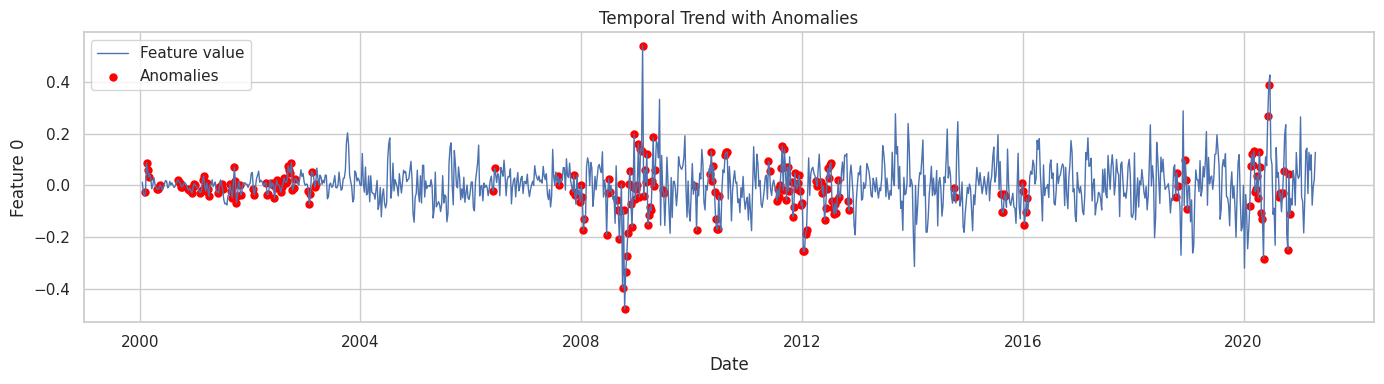

In [ ]:
import matplotlib.pyplot as plt

# Select the feature to plot (e.g., the first one)
feature_idx = 0

# Extract the time index (either from the index or a specific column)
time_index = stationary_df.index  # use stationary_df['Date'] if your DataFrame has a 'Date' column

plt.figure(figsize=(14, 4))
plt.plot(time_index, X[:, feature_idx], label='Feature value', linewidth=1)

# Highlight anomaly points in red
anomaly_points = np.where(y == 1)[0]
plt.scatter(time_index[anomaly_points], X[anomaly_points, feature_idx], color='red', label='Anomalies', s=25)

plt.title('Temporal Trend with Anomalies')
plt.xlabel('Date')
plt.ylabel(f'Feature {feature_idx}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


As you can see from the plot we immediately noticed that the anomalies are **not evenly distributed** across the splits and are generally **very sparse clustered**.
Because of this, the model might not perform perfectly — but it's still worth exploring.

In [ ]:
# Split parameters
n = len(X)
train_size = int(0.7 * n)
val_size = int(0.1 * n)
test_size = n - train_size - val_size

# Temporal split
X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Output info
print(f"[✓] X_train shape: {X_train_scaled.shape}, labels: {np.bincount(y_train.astype(int))}")
print(f"[✓] X_val shape: {X_val_scaled.shape}, labels: {np.bincount(y_val.astype(int))}")
print(f"[✓] X_test shape: {X_test_scaled.shape}, labels: {np.bincount(y_test.astype(int))}")

[✓] X_train shape: (777, 42), labels: [579 198]
[✓] X_val shape: (111, 42), labels: [101  10]
[✓] X_test shape: (222, 42), labels: [193  29]


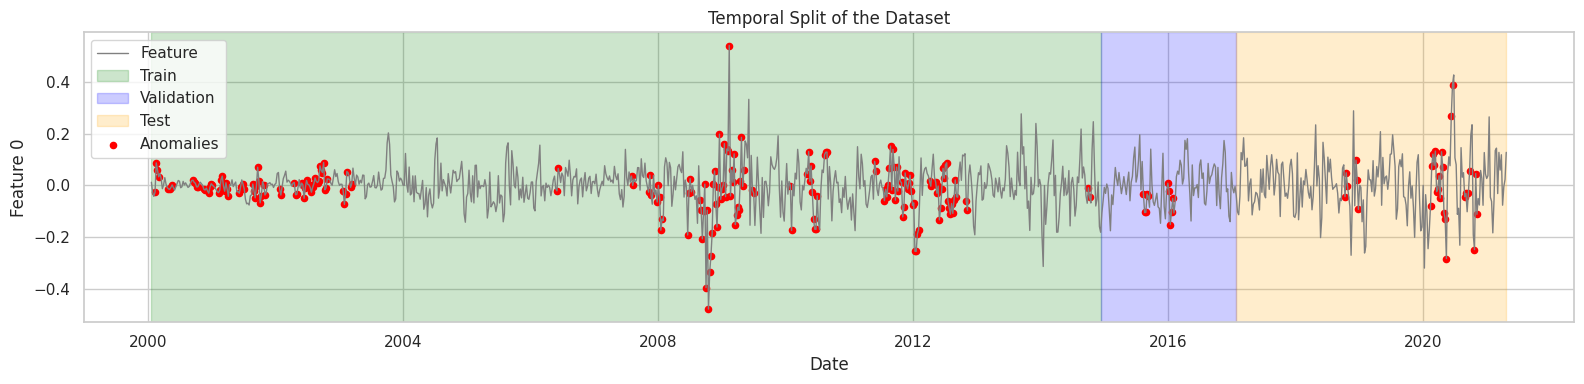

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Select a random feature to visualize
feature_idx = 0
feature = X[:, feature_idx]
dates = stationary_df.index

# Define temporal splits
n = len(X)
train_end = int(0.7 * n)
val_end = int(0.8 * n)

plt.figure(figsize=(16, 4))

# Plot the selected feature
plt.plot(dates, feature, label='Feature', color='gray', linewidth=1)

# Highlight different time regions
plt.axvspan(dates[0], dates[train_end], color='green', alpha=0.2, label='Train')
plt.axvspan(dates[train_end], dates[val_end], color='blue', alpha=0.2, label='Validation')
plt.axvspan(dates[val_end], dates[-1], color='orange', alpha=0.2, label='Test')

# Highlight anomalies in red
anomaly_points = np.where(y == 1)[0]
plt.scatter(dates[anomaly_points], feature[anomaly_points], color='red', label='Anomalies', s=20)

# Add labels and legend
plt.title('Temporal Split of the Dataset')
plt.xlabel('Date')
plt.ylabel(f'Feature {feature_idx}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Class Imbalance Handling:

Since anomalies are rare, the dataset is highly imbalanced.
To mitigate this, we compute and apply **class weights** during training to give more importance to the minority class (anomalies).

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Flatten y_train in case it's not already a 1D array
y_train_flat = y_train.reshape(-1)

# Compute class weights to handle class imbalance
weights = compute_class_weight(
    class_weight='balanced',        # Use balanced mode to adjust weights inversely proportional to class frequencies
    classes=np.unique(y_train_flat),  # Specify all unique classes in the target
    y=y_train_flat                    # Target labels
)

# Convert weights to dictionary format: {class_label: weight}
class_weights = dict(enumerate(weights))
print(class_weights)

{0: np.float64(0.6709844559585493), 1: np.float64(1.9621212121212122)}


### Why window size = 3?

We use a small window size (3) when constructing input sequences for the LSTM.
This decision is based on the **intuition that in financial markets, very recent history has the strongest influence on the present**.
Looking too far back may introduce noise or correlations that are no longer meaningful due to market dynamics changing rapidly.

In [ ]:
window_size = 3
stride = 1

def create_supervised_sequences(X, y, window, stride):
    X_seq, y_seq = [], []
    for i in range(0, len(X) - window + 1, stride):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window-1])  # label associated with the last day in the window
    return np.array(X_seq), np.array(y_seq)

# Create supervised sequences for each dataset split
X_train_seq, y_train_seq = create_supervised_sequences(X_train_scaled, y_train, window_size, stride)
X_val_seq, y_val_seq = create_supervised_sequences(X_val_scaled, y_val, window_size, stride)
X_test_seq, y_test_seq = create_supervised_sequences(X_test_scaled, y_test, window_size, stride)


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, TimeDistributed, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Define the LSTM model architecture
model = Sequential([
    Input(shape=(window_size, X_train_seq.shape[2])),
    LSTM(64, return_sequences=True),       # outputs the full sequence for the next LSTM layer
    Dropout(0.3),
    LSTM(32, return_sequences=False),      # outputs only the final timestep
    Dropout(0.3),
    Dense(1, activation='sigmoid')         # one prediction per input sequence (binary classification)
])

# Define the optimizer
optimizer = Adam(learning_rate=0.0005)

# Compile the model with binary crossentropy loss and accuracy as metric
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

### Overfitting Prevention:

To reduce overfitting, we use two callbacks:
- `EarlyStopping`: to stop training when the validation loss stops improving.
- `ReduceLROnPlateau`: to lower the learning rate when the model plateaus, helping it converge better.


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Early stopping to stop training when validation loss stops improving
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Train the model
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop, reduce_lr],
    class_weight={0: 0.67, 1: 1.96},  # class weights to handle imbalance
)

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.5442 - loss: 0.6758 - val_accuracy: 0.6422 - val_loss: 0.6693 - learning_rate: 5.0000e-04
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6882 - loss: 0.5969 - val_accuracy: 0.6606 - val_loss: 0.6586 - learning_rate: 5.0000e-04
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7246 - loss: 0.5548 - val_accuracy: 0.6697 - val_loss: 0.6508 - learning_rate: 5.0000e-04
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7699 - loss: 0.5190 - val_accuracy: 0.6697 - val_loss: 0.6357 - learning_rate: 5.0000e-04
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8241 - loss: 0.4411 - val_accuracy: 0.7064 - val_loss: 0.5868 - learning_rate: 5.0000e-04
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8294 - loss: 0.4274 - val_accuracy: 0.7064 - val_loss: 0.5478 - learning_rate: 5.0000e-04
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.84

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


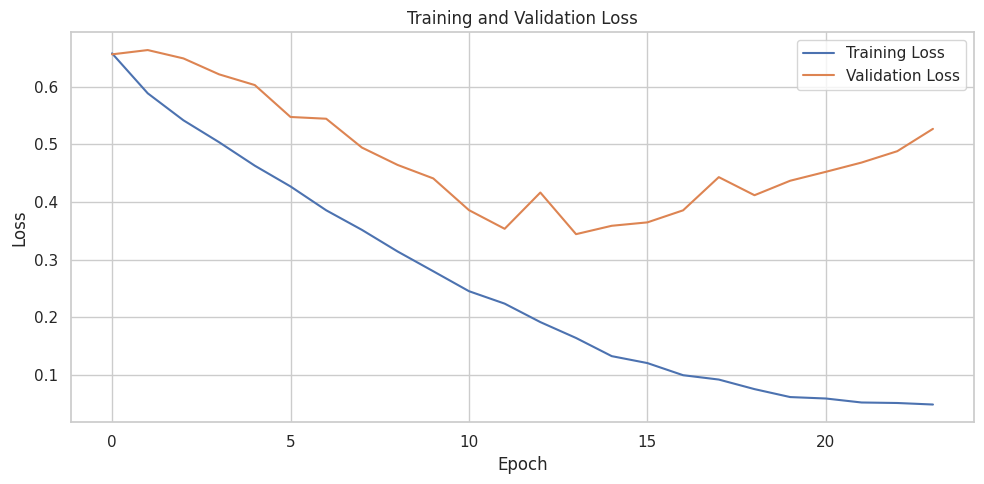

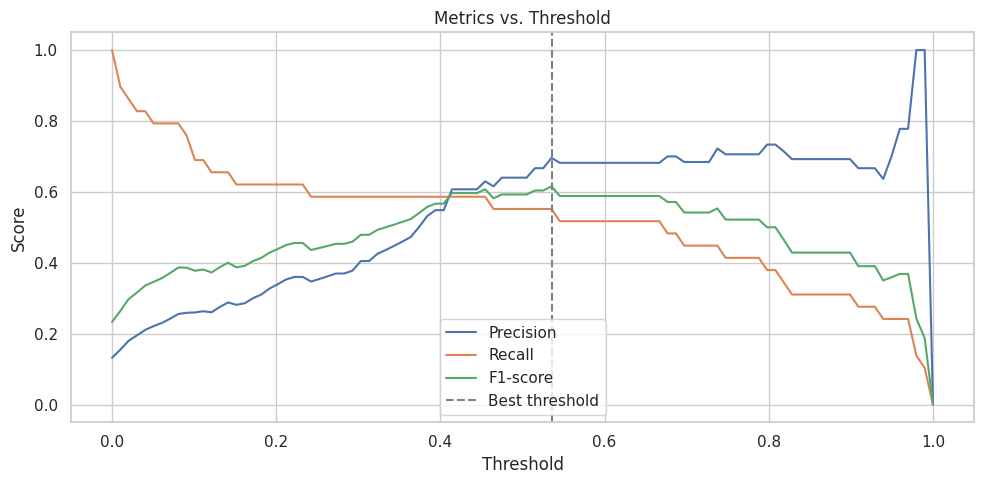

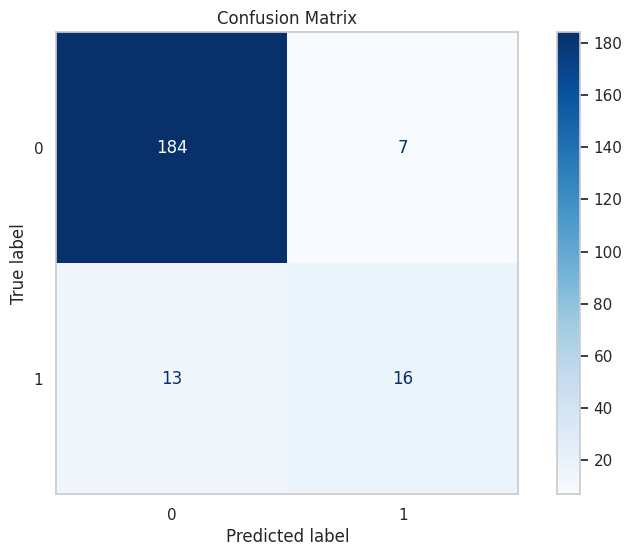

✓ Best threshold: 0.54
Precision: 0.696, Recall: 0.552, F1-score: 0.615


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

# Predict probabilities
y_probs = model.predict(X_test_seq).reshape(-1)
y_true = y_test_seq.reshape(-1)

# Threshold tuning
thresholds = np.linspace(0, 1, 100)
best_f1 = 0
best_threshold = 0
best_metrics = (0, 0, 0)

precisions, recalls, f1s = [], [], []

for t in thresholds:
    y_pred_temp = (y_probs > t).astype(int)
    p, r, f, _ = precision_recall_fscore_support(y_true, y_pred_temp, average='binary')
    precisions.append(p)
    recalls.append(r)
    f1s.append(f)
    if f > best_f1:
        best_f1 = f
        best_threshold = t
        best_metrics = (p, r, f)

# Apply best threshold
y_pred = (y_probs > best_threshold).astype(int)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot precision, recall, and F1 over thresholds
plt.figure(figsize=(10, 5))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1-score')
plt.axvline(best_threshold, color='gray', linestyle='--', label='Best threshold')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Metrics vs. Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# Print best results
print(f"✓ Best threshold: {best_threshold:.2f}")
print(f"Precision: {best_metrics[0]:.3f}, Recall: {best_metrics[1]:.3f}, F1-score: {best_metrics[2]:.3f}")


### Final Considerations and Results

Despite the known limitations of the dataset— especially the low and uneven distribution of anomalies —we were able to build a model that performs reasonably well.

The training and validation loss plot shows a clear **overfitting trend**: while the training loss keeps decreasing steadily, the validation loss starts to increase after a certain point. This confirms the **importance of** our use of **EarlyStopping** and **ReduceLROnPlateau** callbacks to mitigate overfitting as much as possible.

The threshold tuning curve clearly shows the trade-off between precision and recall. We chose the **threshold** that maximized the F1-score (at 0.54), resulting in:

**Precision:** 0.696

**Recall:** 0.552

**F1-score:** 0.615

Finally, the **confusion matrix** shows a balanced performance:
the model correctly identifies 16 out of 29 anomalies while keeping false positives relatively low (7).

Given the complexity of the task and the limited data, this result is promising and shows that the LSTM was able to capture meaningful temporal patterns.

## Unsupervised Models

We now move on to testing a set of **unsupervised anomaly detection models**.  
These models are trained **without using any labels**, relying entirely on the structure and distribution of the data.  
As a result, the response vector **Y is not used during training**.

Most unsupervised models require an estimate of the **expected anomaly rate** (also called **contamination**).  
To keep things consistent and avoid overfitting, we estimate this value from the **validation set only**, rather than the full dataset.  
Additionally, we cap the contamination level at **50%** to prevent unstable or degenerate behavior.

For these experiments, we continue using the original train/validation/test split.  
**No anomaly labels are used during training** — this is the key distinction from the supervised approach.  



In [ ]:
# UNSUPERVISED APPROACHES

print("\n" + "=" * 50)
print("UNSUPERVISED ANOMALY DETECTION METHODS")
print("=" * 50)

# Calculate contamination from cross-validation set
raw_contamination = np.mean(y_cross_val)
print(f"\nEstimated contamination from cross-validation set: {raw_contamination:.4f}")

# Cap contamination for algorithms that have limits
contamination = min(raw_contamination, 0.5)
print(f"Using capped contamination value: {contamination:.4f}")



UNSUPERVISED ANOMALY DETECTION METHODS

Estimated contamination from cross-validation set: 0.5756
Using capped contamination value: 0.5000


In [ ]:
!pip install pyod

## COPOD

COPOD is an unsupervised anomaly detection algorithm that leverages copula functions to model the tails of each feature's distribution.  
This makes it particularly suitable for identifying extreme values without relying on any labeled data.


Training COPOD...

COPOD (Copula-Based Outlier Detection) Performance:
Precision: 0.6692
Recall: 0.7479
F1 Score: 0.7063


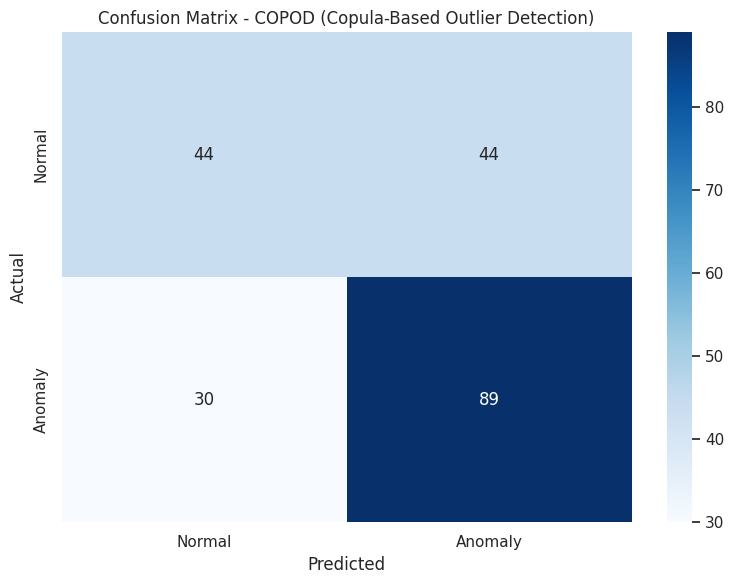

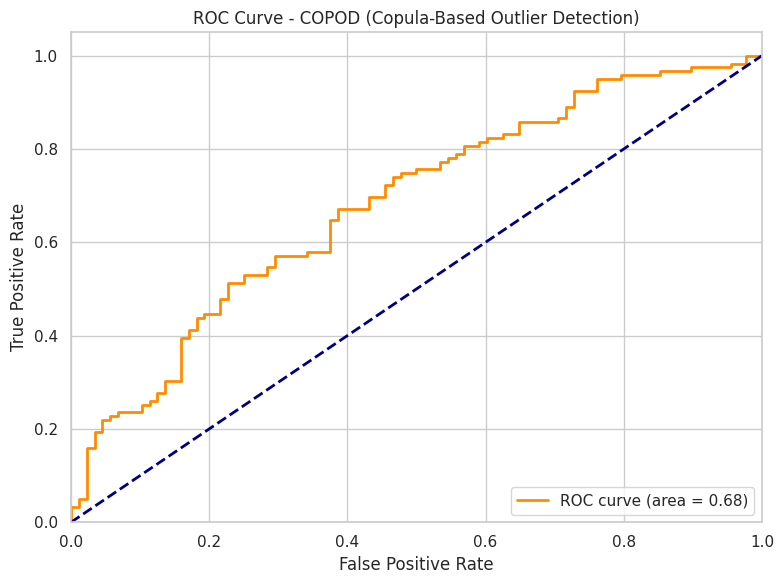

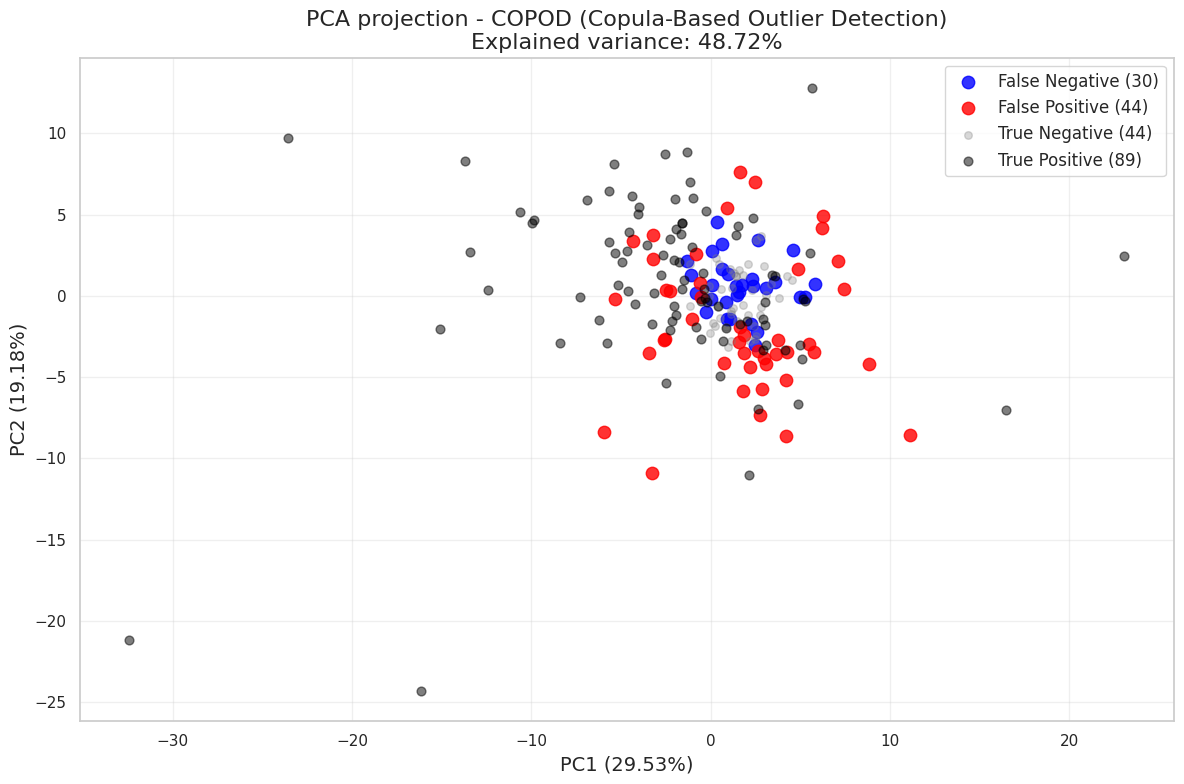

In [ ]:
from pyod.models.copod import COPOD
from sklearn.preprocessing import StandardScaler

# === COPOD (Copula-Based Outlier Detection) ===
print("\nTraining COPOD...")

# Scale the data to improve COPOD's performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the COPOD model
# 'contamination' indicates the expected proportion of anomalies
copod_model = COPOD(contamination=contamination)
copod_model.fit(X_train_scaled)

# Make predictions: 0 = normal, 1 = anomaly
copod_pred = copod_model.predict(X_test_scaled)

# Compute anomaly scores for evaluation and ROC curve
copod_score = copod_model.decision_function(X_test_scaled)

# Evaluate the model using precision, recall, F1 score, confusion matrix, and ROC curve
copod_metrics = evaluate_model(y_test, copod_pred, copod_score, "COPOD (Copula-Based Outlier Detection)")

# Visualize the classification results in PCA space
visualize_pca(X_test_scaled, y_test, copod_pred, "COPOD (Copula-Based Outlier Detection)")

# Store results for later comparison with other models
results.append(("COPOD (Copula-Based Outlier Detection)", *copod_metrics))


In our evaluation, however, **COPOD underperforms** compared to both the **supervised models** (XGBoost) and the **baseline MVG model**.  
This result is expected since without access to labeled anomalies during training, COPOD can only rely on general distributional properties of the features, without learning the specific patterns associated with past anomalies.

Moreover, financial time series often exhibit **complex, nonlinear, and multivariate dependencies**, which may not be fully captured by COPOD's feature-wise tail modeling.  
As a result, the model may struggle to distinguish between harmless outliers and truly risky events in such high-dimensional settings.




# LSTM Autoencoder with Active Learning

The model is trained in an **unsupervised** way on normal data, then iteratively improves by selecting high-error sequences as potential anomalies. However, it incorporates a **semi-supervised** component through active learning, where high-error samples are assumed to be anomalies, labeled accordingly, and included in subsequent training rounds to refine the model.

### Data preprocessing
The data preprocessing involves loading financial time series and metadata, converting dates, and extracting anomaly labels. To ensure stationarity, log-differences are applied to indices and currencies, while first differences are used for interest rates. The dataset is then split into training (only normal data), validation, and test sets, and standardized. Finally, time sequences of fixed length are created to feed into the LSTM model.

In [ ]:
# Import necessary libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

drive.mount('/content/drive')
file_path = ('/content/drive/MyDrive/FINTECH/Dataset4_EWS.xlsx')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data columns: ['Data', 'BDIY', 'CRY', 'Cl1', 'DXY', 'ECSURPUS', 'EMUSTRUU', 'EONIA', 'GBP', 'GT10', 'GTDEM10Y', 'GTDEM2Y', 'GTDEM30Y', 'GTGBP20Y', 'GTGBP2Y', 'GTGBP30Y', 'GTITL10YR', 'GTITL2YR', 'GTITL30YR', 'GTJPY10YR', 'GTJPY2YR', 'GTJPY30YR', 'JPY', 'LF94TRUU', 'LF98TRUU', 'LG30TRUU', 'LMBITR', 'LP01TREU', 'LUACTRUU', 'LUMSTRUU', 'MXBR', 'MXCN', 'MXEU', 'MXIN', 'MXJP', 'MXRU', 'MXUS', 'US0001M', 'USGG2YR', 'USGG30YR', 'USGG3M', 'VIX', 'XAUBGNL', 'Y']
Data shape: (1111, 42)
Total number of records: 1111
Time period: from 01/11/2000 to 04/20/2021
Frequency: W-TUE
Number of variables: 42
Number of anomalies: 237 (21.33%)

Metadata and statistics:


,Ticker,Description,Mean,Std.Dev,Min,Max,Missing values,Missing (%)
0,BDIY,Baltic Dry Index,2259.860486,2017.811888,291.00000,11793.00000,0,0.00%
1,CRY,TR/CC CRB ER Index,245.247649,68.278081,106.29290,467.57000,0,0.00%
2,Cl1,Generic 1st 'CL' Future,60.708101,25.900813,10.01000,140.97000,0,0.00%
3,DXY,DOLLAR INDEX SPOT,90.934982,11.379095,71.32900,119.82000,0,0.00%
4,ECSURPUS,Bloomberg ECO US Surprise Inde,0.036153,0.349453,-0.97400,0.99100,0,0.00%
5,EMUSTRUU,EM USD Aggregate,704.379495,309.951768,230.52670,1286.35300,0,0.00%
6,EONIA,EMMI EURO OverNight Index Aver,1.363676,1.721894,-0.49800,5.73000,0,0.00%
7,GBP,British Pound Spot,1.569618,0.212340,1.17230,2.08520,0,0.00%
8,GT10,US TREASURY N/B,3.266748,1.332464,0.50800,6.74800,0,0.00%
9,GTDEM10Y,BUNDESREPUB. DEUTSCHLAND,2.448365,1.851558,-0.79400,5.64400,0,0.00%


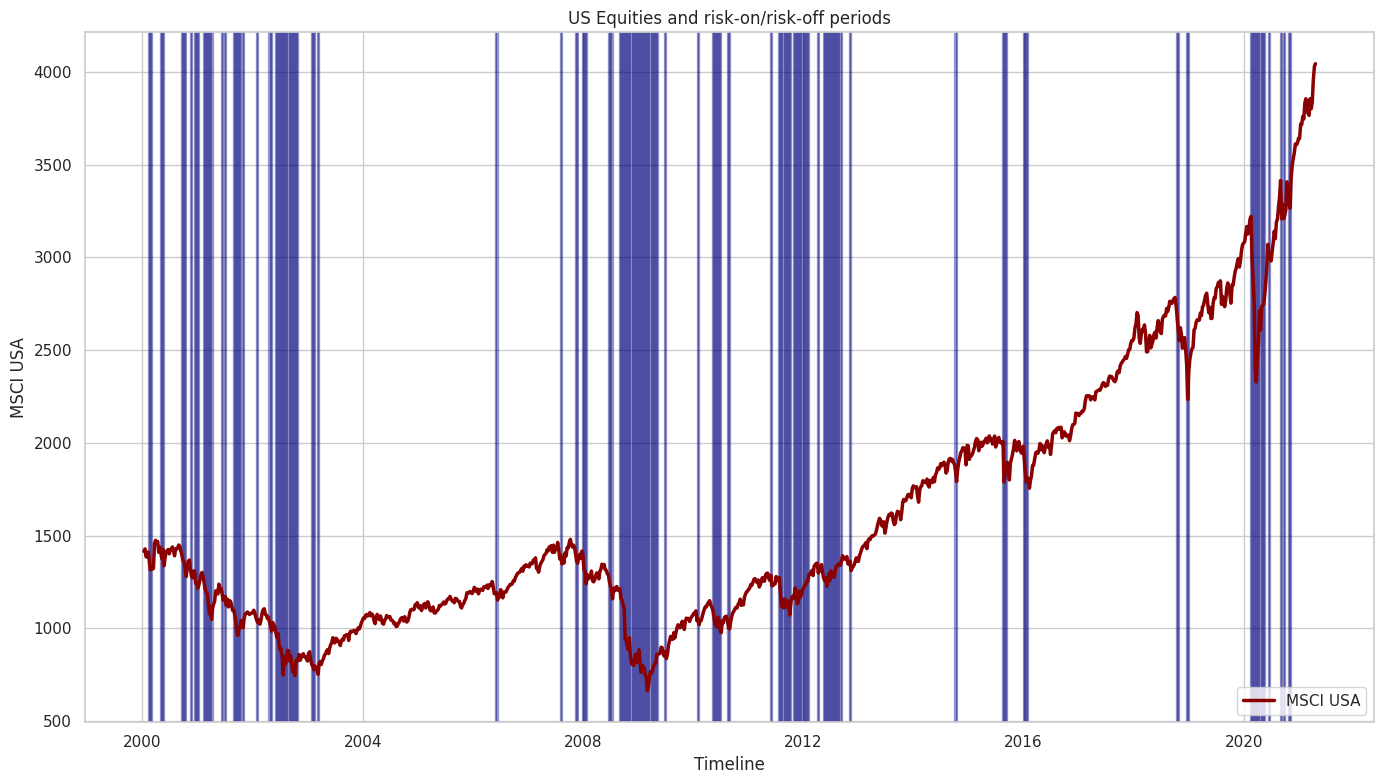

In [ ]:
# Set visualization style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

# Load the data from the Excel file
# First sheet contains market data with dates and anomaly labels, second sheet contains metadata
data_df = pd.read_excel(file_path, sheet_name='Markets')
metadata_df = pd.read_excel(file_path, sheet_name='Metadata')

# Check the structure of the loaded data
print("Data columns:", data_df.columns.tolist())

# Extract date and anomaly label columns
date_col = 'Date' if 'Date' in data_df.columns else data_df.columns[0]
y_col = 'Y' if 'Y' in data_df.columns else None

# Convert dates to datetime format
data_df[date_col] = pd.to_datetime(data_df[date_col], dayfirst=True)  # Date format is dd/mm/yy

# Set date as index
data_df = data_df.set_index(date_col)

# Extract features (all columns except Y if it exists)
if y_col:
    X_df = data_df.drop(y_col, axis=1)
    y = data_df[y_col].values
else:
    X_df = data_df
    y = None

# Display basic information about the dataset
print(f"Data shape: {X_df.shape}")
print(f"Total number of records: {len(X_df)}")
print(f"Time period: from {X_df.index.min().strftime('%m/%d/%Y')} to {X_df.index.max().strftime('%m/%d/%Y')}")
print(f"Frequency: {pd.infer_freq(X_df.index) or 'Weekly'}")
print(f"Number of variables: {X_df.shape[1]}")
if y_col:
    print(f"Number of anomalies: {np.sum(y == 1)} ({np.mean(y == 1)*100:.2f}%)")

# Create a more comprehensive metadata table with additional statistics
enhanced_metadata = []

# Determine the correct column names for ticker and description
ticker_col = 'ticker' if 'ticker' in metadata_df.columns else metadata_df.columns[0]
desc_col = 'description' if 'description' in metadata_df.columns else metadata_df.columns[1] if len(metadata_df.columns) > 1 else ticker_col

for ticker in X_df.columns:
    # Get metadata for this ticker if available
    meta_row = metadata_df[metadata_df[ticker_col] == ticker] if ticker in metadata_df[ticker_col].values else pd.DataFrame()

    # Get description or use ticker if not found
    description = meta_row[desc_col].values[0] if not meta_row.empty and desc_col in meta_row.columns else ticker

    # Calculate statistics for this series
    series = X_df[ticker]

    enhanced_metadata.append({
        'Ticker': ticker,
        'Description': description,
        'Mean': series.mean(),
        'Std.Dev': series.std(),
        'Min': series.min(),
        'Max': series.max(),
        'Missing values': series.isna().sum(),
        'Missing (%)': f"{series.isna().mean()*100:.2f}%"
    })

# Create enhanced metadata dataframe
enhanced_meta_df = pd.DataFrame(enhanced_metadata)

# Display the enhanced metadata
print("\nMetadata and statistics:")
display(enhanced_meta_df)

# Create a plot with anomalies as vertical bars and MXUS as a line
if y_col and 'MXUS' in X_df.columns:
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot MXUS line
    ax.plot(X_df.index, X_df['MXUS'], color='darkred', linewidth=2.5, label='MSCI USA')

    # Get the y-axis limits after plotting MXUS
    y_min, y_max = ax.get_ylim()

    # For each anomaly point (Y=1), create a vertical span across the entire plot
    for i, (date, is_anomaly) in enumerate(zip(X_df.index, y)):
        if is_anomaly == 1:
            ax.axvspan(date, date + pd.Timedelta(days=7), alpha=0.3, color='navy', label='Risk-on/Risk-off' if i == 0 else "")

    # Set labels and title
    ax.set_xlabel('Timeline')
    ax.set_ylabel('MSCI USA')
    ax.set_title('US Equities and risk-on/risk-off periods')

    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='best')

    plt.tight_layout()
    plt.show()
else:
    print("Either 'Y' column or 'MXUS' column is missing in the dataset.")


In [ ]:
# Make data stationary based on variable type
# So w define lists of variables by type
indices_currencies = [col for col in X_df.columns if col in [
    'XAUBGNL', 'BDIY', 'CRY', 'Cl1', 'DXY', 'EMUSTRUU', 'GBP', 'JPY', 'LF94TRUU',
    'LF98TRUU', 'LG30TRUU', 'LMBITR', 'LP01TREU', 'LUACTRUU', 'LUMSTRUU',
    'MXBR', 'MXCN', 'MXEU', 'MXIN', 'MXJP', 'MXRU', 'MXUS', 'VIX'
]]

interest_rates = [col for col in X_df.columns if col in [
    'EONIA', 'GTDEM10Y', 'GTDEM2Y', 'GTDEM30Y', 'GTGBP20Y', 'GTGBP2Y', 'GTGBP30Y',
    'GTITL10YR', 'GTITL2YR', 'GTITL30YR', 'GTJPY10YR', 'GTJPY2YR', 'GTJPY30YR',
    'US0001M', 'USGG3M', 'USGG2YR', 'GT10', 'USGG30YR'
]]

# Create a new dataframe for stationary data
stationary_df = pd.DataFrame(index=X_df.index[1:])

# Apply log-differences to indices and currencies (always positive)
for col in indices_currencies:
    if col in X_df.columns:
        stationary_df[col] = np.diff(np.log(X_df[col]))

# Apply first differences to interest rates (can be negative or very close to 0)
for col in interest_rates:
    if col in X_df.columns:
        stationary_df[col] = np.diff(X_df[col])

# Keep Bloomberg Economic US Surprise Index as is (already stationary)
if 'ECSURPUS' in X_df.columns:
    stationary_df['ECSURPUS'] = X_df['ECSURPUS'].values[1:]

# Adjust the response variable to match the new data length
if y is not None:
    y_stationary = y[1:]
else:
    y_stationary = None


In [ ]:
# Step 1: split data into training, validation, and test sets
from sklearn.preprocessing import StandardScaler

# Set visualization style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]

# Convert to numpy arrays for easier manipulation
X = stationary_df.values
y = y_stationary

# Step 1: Creating training/cross-validation/test set with reshuffling

# Separate normal and anomalous examples
X_normal = X[y == 0]
X_anomaly = X[y == 1]

# Calculate sizes for each set
n_normal = X_normal.shape[0]
n_anomaly = X_anomaly.shape[0]

# Training set: 80% of normal examples
train_size = int(0.8 * n_normal)
X_train = X_normal[:train_size]

# Cross-validation set: 10% of normal examples and 50% of anomalies
cv_normal_size = int(0.1 * n_normal)
cv_anomaly_size = int(0.5 * n_anomaly)
X_cv_normal = X_normal[train_size:train_size + cv_normal_size]
X_cv_anomaly = X_anomaly[:cv_anomaly_size]
X_cross_val = np.vstack((X_cv_normal, X_cv_anomaly))
y_cross_val = np.hstack((np.zeros(cv_normal_size), np.ones(cv_anomaly_size)))

# Test set: 10% of normal examples and 50% of anomalies
X_test_normal = X_normal[train_size + cv_normal_size:]
X_test_anomaly = X_anomaly[cv_anomaly_size:]
X_test = np.vstack((X_test_normal, X_test_anomaly))
y_test = np.hstack((np.zeros(len(X_test_normal)), np.ones(len(X_test_anomaly))))

# We'll standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_cross_val = scaler.transform(X_cross_val)
X_test = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]} (all normal)")
print(f"Cross-validation set size: {X_cross_val.shape[0]} ({cv_normal_size} normal, {cv_anomaly_size} anomalies)")
print(f"Test set size: {X_test.shape[0]} ({len(X_test_normal)} normal, {len(X_test_anomaly)} anomalies)")


Training set size: 698 (all normal)
Cross-validation set size: 205 (87 normal, 118 anomalies)
Test set size: 207 (88 normal, 119 anomalies)


### Model training and evaluation

Using device: cpu
Training set size: 698 (all normal)
Cross-validation set size: 205 (87 normal, 118 anomalies)
Test set size: 207 (88 normal, 119 anomalies)

Iteration 1/20
Train Loss: 1.6592 | Validation Loss: 2.0040

Iteration 2/20
Train Loss: 1.3407 | Validation Loss: 2.0039

Iteration 3/20
Train Loss: 1.2961 | Validation Loss: 2.0035

Iteration 4/20
Train Loss: 1.2712 | Validation Loss: 2.0030

Iteration 5/20
Train Loss: 1.2492 | Validation Loss: 2.0023

Iteration 6/20
Train Loss: 1.2306 | Validation Loss: 2.0014

Iteration 7/20
Train Loss: 1.2133 | Validation Loss: 2.0004

Iteration 8/20
Train Loss: 1.1959 | Validation Loss: 1.9994

Iteration 9/20
Train Loss: 1.1806 | Validation Loss: 1.9984

Iteration 10/20
Train Loss: 1.1668 | Validation Loss: 1.9974

Iteration 11/20
Train Loss: 1.1524 | Validation Loss: 1.9964

Iteration 12/20
Train Loss: 1.1390 | Validation Loss: 1.9954

Iteration 13/20
Train Loss: 1.1273 | Validation Loss: 1.9943

Iteration 14/20
Train Loss: 1.1166 | Validat

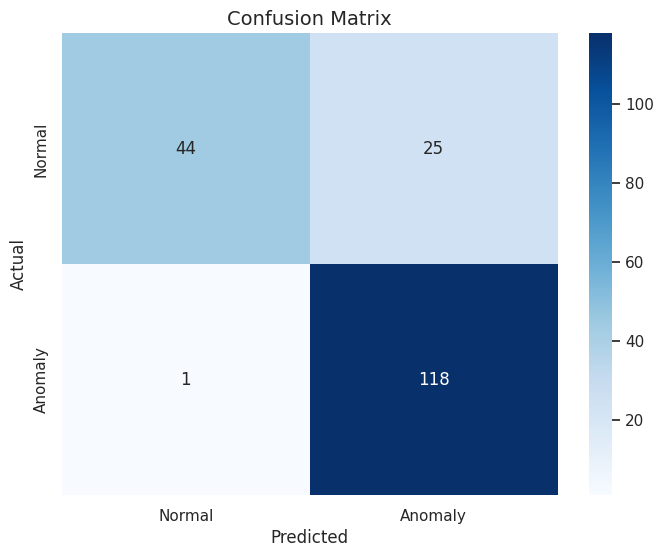

Test Accuracy: 0.8617
Precision: 0.8252
Recall: 0.9916
F1 Score: 0.9008


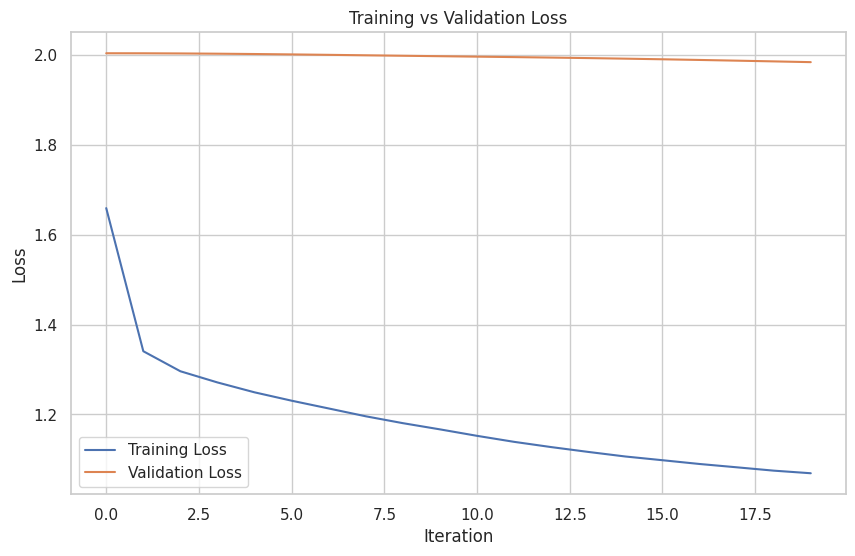

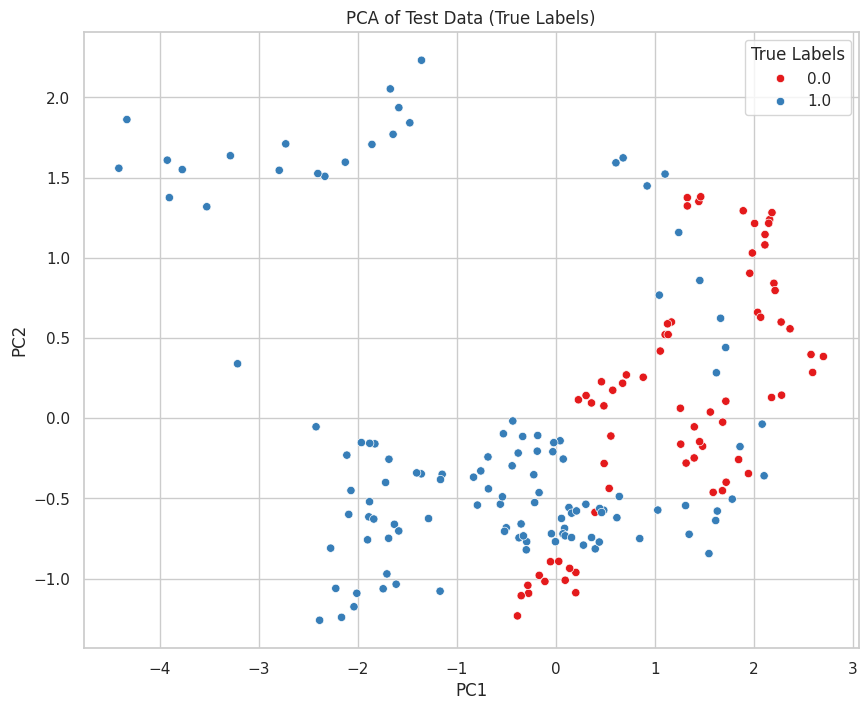

In [ ]:
# LSTM Autoencoder Anomaly Detection - Full Pipeline

# 1. Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

# 2. Reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 3. Data Preprocessing (assuming stationary_df and y_stationary already exist)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]


print(f"Training set size: {X_train.shape[0]} (all normal)")
print(f"Cross-validation set size: {X_cross_val.shape[0]} ({cv_normal_size} normal, {cv_anomaly_size} anomalies)")
print(f"Test set size: {X_test.shape[0]} ({len(X_test_normal)} normal, {len(X_test_anomaly)} anomalies)")

# 4. Sequence creation
def create_sequences(data, sequence_length=20):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        seq = data[i:i+sequence_length]
        sequences.append(seq)
    return np.array(sequences)

sequence_length = 20
X_train_seq = create_sequences(X_train, sequence_length)
X_cv_seq = create_sequences(X_cross_val, sequence_length)
X_test_seq = create_sequences(X_test, sequence_length)

X_train_tensor = torch.FloatTensor(X_train_seq).to(device)
X_cv_tensor = torch.FloatTensor(X_cv_seq).to(device)
X_test_tensor = torch.FloatTensor(X_test_seq).to(device)

adjust = sequence_length - 1
y_cv_adj = y_cross_val[adjust:]
y_test_adj = y_test[adjust:]

X_train_label = X_train_tensor[:100]
X_train_unlabeled = X_train_tensor[100:]
y_train_label = torch.zeros(X_train_label.size(0)).to(device)

# 5. LSTM Autoencoder class
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, latent_dim=8, num_layers=2, dropout_rate=0.3):
        super(LSTMAutoencoder, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.encoder_lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers=num_layers,
            batch_first=True, dropout=dropout_rate if num_layers > 1 else 0
        )
        self.dropout_enc = nn.Dropout(dropout_rate)

        self.hidden_to_latent = nn.Linear(hidden_dim * num_layers, latent_dim) # Adjust size for multi-layer output
        self.latent_to_hidden = nn.Linear(latent_dim, hidden_dim * num_layers) # Adjust size for multi-layer input

        self.decoder_lstm = nn.LSTM(
            hidden_dim, hidden_dim, num_layers=num_layers,
            batch_first=True, dropout=dropout_rate if num_layers > 1 else 0
        )
        self.dropout_dec = nn.Dropout(dropout_rate)

        self.output_layer = nn.Linear(hidden_dim, input_dim)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)

        enc_out, (hidden, cell) = self.encoder_lstm(x, (h0, c0))
        enc_out = self.dropout_enc(enc_out)

        # Flatten the hidden states from all layers before passing to latent
        latent = self.hidden_to_latent(hidden.permute(1, 0, 2).reshape(batch_size, -1))

        # Project latent back to hidden size and reshape for decoder
        hidden_dec = self.latent_to_hidden(latent).view(batch_size, self.num_layers, self.hidden_dim).permute(1, 0, 2)
        c0_dec = torch.zeros_like(hidden_dec).to(device) # Initialize cell state for decoder

        # The decoder input should be a sequence, often derived from the latent space
        # A common approach is to repeat the last encoder output or the initial state
        # Here, we'll use the hidden_dec as the initial state and provide a sequence of zeros
        # or simply rely on the initial hidden state and a single step input if the decoder is simple
        # For autoencoder, the decoder typically takes the *latent* representation and outputs the sequence.
        # A simple approach is to feed the decoded hidden state at each time step.
        # The input to the decoder LSTM should have shape (batch_size, seq_len, hidden_dim)
        # Here, we can repeat the latent_to_hidden output across the sequence length dimension
        decoder_input_seq = hidden_dec[-1].unsqueeze(1).repeat(1, seq_len, 1) # Use the last layer's output and repeat

        # Pass the input sequence and the initial hidden/cell states to the decoder
        dec_out, _ = self.decoder_lstm(decoder_input_seq, (hidden_dec, c0_dec))

        dec_out = self.dropout_dec(dec_out)

        # Apply batch norm after the LSTM layer and before the output linear layer
        # Need to flatten for BatchNorm1d and then reshape back
        batch_size, seq_len, hidden_dim = dec_out.size()
        dec_out = dec_out.contiguous().view(-1, hidden_dim)
        dec_out = self.batch_norm(dec_out)
        dec_out = dec_out.view(batch_size, seq_len, hidden_dim)


        return self.output_layer(dec_out)

    def encode(self, x):
        batch_size, seq_len, _ = x.size()
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        _, (hidden, _) = self.encoder_lstm(x, (h0, c0))
        # Flatten the hidden states from all layers before passing to latent
        return self.hidden_to_latent(hidden.permute(1, 0, 2).reshape(batch_size, -1))

# 6. Training and Evaluation Functions
def train_labeled_data(model, X_labeled, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_labeled)
    loss = criterion(outputs, X_labeled)
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate_loss(model, X_val, criterion):
    model.eval()
    with torch.no_grad():
        outputs = model(X_val)
        loss = criterion(outputs, X_val)
    return loss.item()

def propagate_labels(model, X_unlabeled):
    model.eval()
    with torch.no_grad():
        outputs = model(X_unlabeled)
        recon_errors = ((outputs - X_unlabeled) ** 2).mean(dim=[1, 2])
    return recon_errors

def find_best_threshold(y_true, reconstruction_errors):
    best_f1 = 0
    best_thresh = 0

    if len(y_true) != len(reconstruction_errors):
        min_len = min(len(y_true), len(reconstruction_errors))
        y_true = y_true[:min_len]
        reconstruction_errors = reconstruction_errors[:min_len]

    for thresh in np.linspace(min(reconstruction_errors), max(reconstruction_errors), 5000):
        y_pred = (reconstruction_errors > thresh).cpu().numpy().astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
    return best_thresh, best_f1

# 7. Training loop with Active Learning
iterations = 20
model = LSTMAutoencoder(
    input_dim=X_train_tensor.shape[2],
    hidden_dim=64,
    latent_dim=8,
    num_layers=2,           # 🔼 aumentato
    dropout_rate=0.3        # ✅ aggiunto
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 10
counter = 0

for i in range(iterations):
    print(f"\nIteration {i+1}/{iterations}")
    # Ensure X_train_label has the correct shape for the model (batch_size, seq_len, input_dim)
    # It seems X_train_label already has this shape from create_sequences and batching in Active Learning part
    train_loss = train_labeled_data(model, X_train_label, optimizer, criterion)

    # Ensure X_cv_normal_tensor has the correct shape
    # It seems X_cv_normal_tensor also has this shape
    #X_cv_normal_tensor = X_cv_tensor[y_cv_adj == 0]
    #val_loss = evaluate_loss(model, X_cv_normal_tensor, criterion)
    val_loss = evaluate_loss(model, X_cv_tensor, criterion)


    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping: validation loss hasn't improved in the last 5 epochs.")
        break

    # Propagate labels and select data (this part of the active learning logic remains the same)
    recon_errors = propagate_labels(model, X_train_unlabeled)
    # Use y_cv_adj to find the threshold as intended in the original code
    threshold, _ = find_best_threshold(y_cv_adj, recon_errors) # Use CV set labels for threshold tuning
    predicted_labels = (recon_errors > threshold).int()

    # Active learning selection
    selected_data = X_train_unlabeled[predicted_labels == 1]
    if len(selected_data) > 0:
        X_train_label = torch.cat([X_train_label, selected_data], dim=0)
        # The labels for the newly selected data from X_train_unlabeled are assumed to be anomalies (1) based on the threshold.
        # This is a key part of the active learning strategy here.
        new_labels = torch.ones(selected_data.size(0)).to(device) # Assign label 1 to selected anomalies
        y_train_label = torch.cat([y_train_label, new_labels], dim=0)

    scheduler.step(val_loss)


# 8. Final Evaluation
model.eval()
test_recon_errors = propagate_labels(model, X_test_tensor)
# Use y_test_adj to find the best threshold *for evaluation purposes* on the test set,
# although in a real scenario you would use the threshold found on the CV set.
# However, the original code's find_best_threshold is used here on the test set,
# which means the threshold is being optimized *on the test set labels*, which is data leakage.
# To fix this and adhere to standard practice, use the best_epsilon found during CV.
# Let's use the threshold found on the CV set (threshold from the loop, using y_cv_adj) for final testing.
# We need to store the best threshold from the CV loop.

# Re-run threshold finding on CV set one last time after training is done, using the final model
model.eval()
cv_recon_errors = propagate_labels(model, X_cv_tensor)
final_best_threshold_cv, _ = find_best_threshold(y_cv_adj, cv_recon_errors)


# Use the threshold found on the CV set to make predictions on the test set
y_test_pred = (test_recon_errors > final_best_threshold_cv).cpu().numpy().astype(int)


cm = confusion_matrix(y_test_adj, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])

plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
test_accuracy = (y_test_pred == y_test_adj[:len(y_test_pred)]).mean()
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision_score(y_test_adj, y_test_pred, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test_adj, y_test_pred, zero_division=0):.4f}")
print(f"F1 Score: {f1_score(y_test_adj, y_test_pred, zero_division=0):.4f}")

# 9. Plot training vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# 10. PCA Visualization
def average_sequences(X_seq):
    return np.mean(X_seq, axis=1)

X_test_avg = average_sequences(X_test_seq)

def visualize_autoencoder_pca(X, y_true, y_pred, reconstruction_errors):
    # Rimuove i campioni che contengono NaN
    mask = ~np.isnan(X).any(axis=1)
    X = X[mask]
    y_true = np.array(y_true)[mask]
    y_pred = np.array(y_pred)[mask]
    reconstruction_errors = reconstruction_errors[mask]

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
    df["True Labels"] = y_true
    df["Pred Labels"] = y_pred
    df["Reconstruction Error"] = reconstruction_errors.cpu().numpy()

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x="PC1", y="PC2", hue="True Labels", palette="Set1", data=df)
    plt.title("PCA of Test Data (True Labels)")
    plt.show()

visualize_autoencoder_pca(X_test_avg, y_test_adj, y_test_pred, test_recon_errors)

## Ensemble
**Ensemble methods** are approaches that combine multiple models to make more robust and accurate predictions.

In this step, we build an ensemble anomaly detector by combining three different models: an Autoencoder, XGBoost, and Local Outlier Factor (LOF).  
Each model captures anomalies from a different perspective — reconstruction error, classification probability, and local density.

To ensure consistency, all scores are normalized to a [0, 1] range and then averaged to produce a final anomaly score.  





In [ ]:
# Autoencoder for Ensemble (Minimal Version)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)

# Create DataLoader
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=16):
        super(Autoencoder, self).__init__()
        layer1_size = max(input_dim // 2, encoding_dim * 2)
        layer2_size = max(layer1_size // 2, encoding_dim)

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, layer1_size),
            nn.BatchNorm1d(layer1_size),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(layer1_size, layer2_size),
            nn.BatchNorm1d(layer2_size),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(layer2_size, encoding_dim),
            nn.BatchNorm1d(encoding_dim),
            nn.ReLU(True)
        )

        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, layer2_size),
            nn.BatchNorm1d(layer2_size),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(layer2_size, layer1_size),
            nn.BatchNorm1d(layer1_size),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(layer1_size, input_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

# Initialize model
input_dim = X_train_scaled.shape[1]
encoding_dim = min(16, input_dim // 4)
model = Autoencoder(input_dim, encoding_dim).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Train model
def train_autoencoder(model, train_loader, num_epochs=200, patience=20):
    best_loss = float('inf')
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for data, _ in train_loader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * data.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            no_improve_epochs = 0
            torch.save(model.state_dict(), 'best_autoencoder.pth')
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                break

    model.load_state_dict(torch.load('best_autoencoder.pth'))
    return model

model = train_autoencoder(model, train_loader)

# Compute reconstruction error
def compute_reconstruction_error(model, data_tensor):
    model.eval()
    with torch.no_grad():
        reconstructions = model(data_tensor)
        mse = ((reconstructions - data_tensor) ** 2).mean(dim=1).cpu().numpy()
    return mse

# Generate test errors for ensemble
test_errors = compute_reconstruction_error(model, X_test_tensor)


Using device: cpu


In [ ]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 15.2 MB/s eta 0:00:00


In [ ]:
#Local Outlier Factor (Optimized for Ensemble)
from sklearn.neighbors import LocalOutlierFactor
import optuna
from optuna import Trial, visualization

print("\nTraining and optimizing Local Outlier Factor...")

# Optuna objective function
def objective_lof(trial: Trial):
    n_neighbors = trial.suggest_int("n_neighbors", 5, 50)
    leaf_size = trial.suggest_int("leaf_size", 10, 50)
    metric = trial.suggest_categorical("metric", ["euclidean", "manhattan", "chebyshev", "minkowski"])

    model = LocalOutlierFactor(
        n_neighbors=n_neighbors,
        leaf_size=leaf_size,
        metric=metric,
        contamination=contamination,
        novelty=True
    )
    model.fit(X_train_scaled)
    y_pred = (model.predict(X_cross_val) == -1).astype(int)
    return f1_score(y_cross_val, y_pred, zero_division=0)

# Optimize hyperparameters
study_lof = optuna.create_study(direction="maximize")
study_lof.optimize(objective_lof, n_trials=50, show_progress_bar=True)

# Retrain with best params
best_lof = LocalOutlierFactor(**study_lof.best_params, contamination=contamination, novelty=True)
best_lof.fit(X_train_scaled)

# Final predictions and anomaly scores
lof_pred_final = (best_lof.predict(X_test_scaled) == -1).astype(int)
lof_score_final = -best_lof.decision_function(X_test_scaled)  # For ensemble: higher = more anomalous


[I 2025-05-28 07:50:44,755] A new study created in memory with name: no-name-d69b7455-e4c0-4b4b-8afc-9f2bbcc539b8



Training and optimizing Local Outlier Factor...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-28 07:50:44,869] Trial 0 finished with value: 0.7604562737642585 and parameters: {'n_neighbors': 25, 'leaf_size': 27, 'metric': 'euclidean'}. Best is trial 0 with value: 0.7604562737642585.
[I 2025-05-28 07:50:44,902] Trial 1 finished with value: 0.75 and parameters: {'n_neighbors': 48, 'leaf_size': 25, 'metric': 'minkowski'}. Best is trial 0 with value: 0.7604562737642585.
[I 2025-05-28 07:50:44,960] Trial 2 finished with value: 0.7674418604651163 and parameters: {'n_neighbors': 35, 'leaf_size': 23, 'metric': 'manhattan'}. Best is trial 2 with value: 0.7674418604651163.
[I 2025-05-28 07:50:44,994] Trial 3 finished with value: 0.7575757575757576 and parameters: {'n_neighbors': 32, 'leaf_size': 43, 'metric': 'minkowski'}. Best is trial 2 with value: 0.7674418604651163.
[I 2025-05-28 07:50:45,036] Trial 4 finished with value: 0.752851711026616 and parameters: {'n_neighbors': 49, 'leaf_size': 41, 'metric': 'euclidean'}. Best is trial 2 with value: 0.7674418604651163.
[I 2025-05


--- Ensemble with threshold = 0.5 ---

Ensemble (threshold = 0.5) Performance:
Precision: 0.7561
Recall: 0.7815
F1 Score: 0.7686


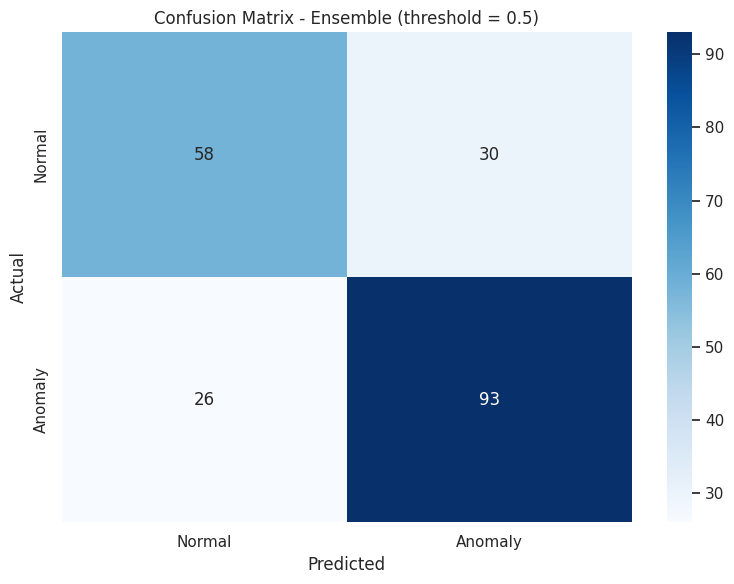

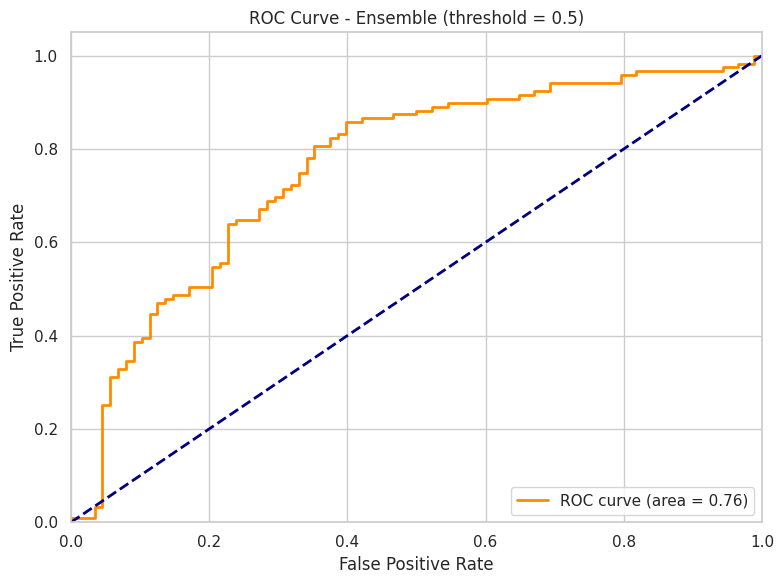

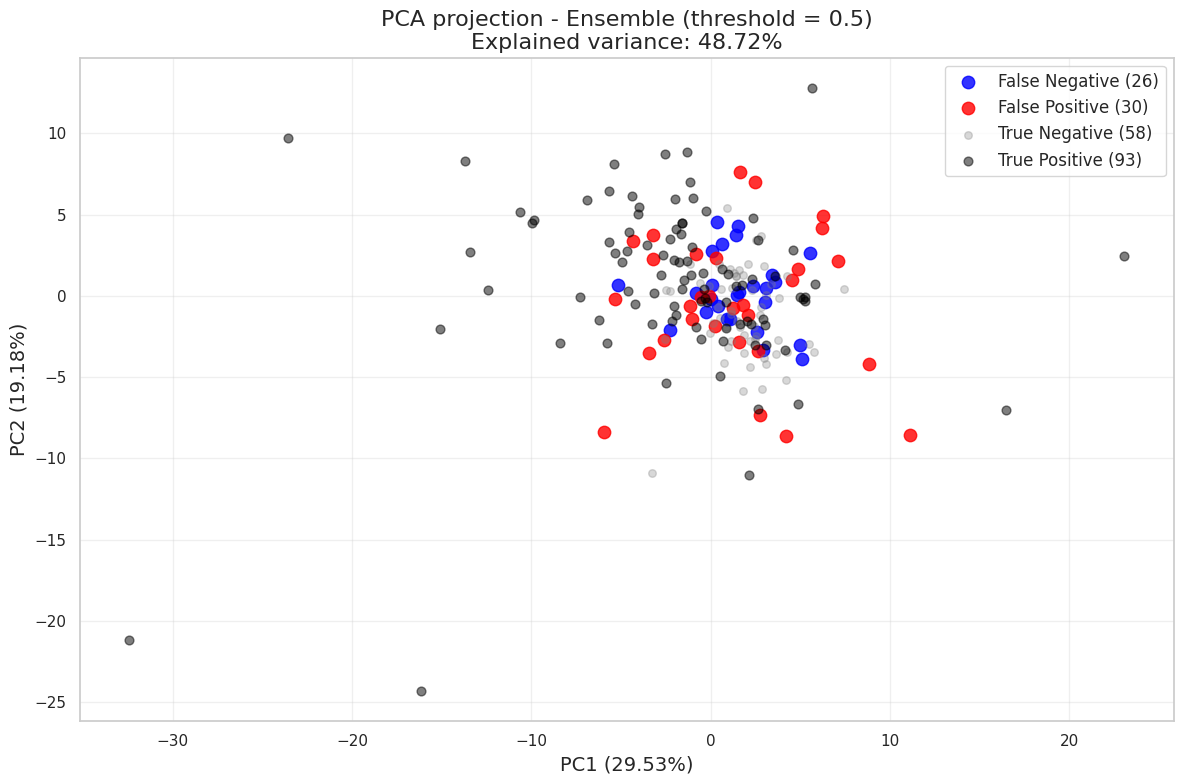

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


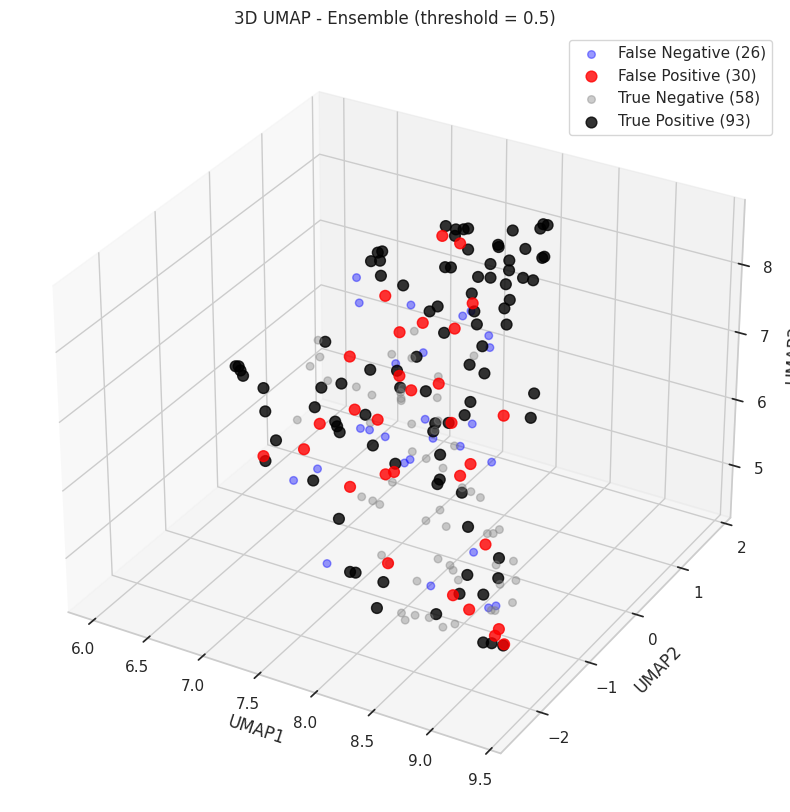


Best threshold from ROC (Youden's J): 0.4561

--- Ensemble with optimal threshold ---

Ensemble (optimal threshold) Performance:
Precision: 0.7426
Recall: 0.8487
F1 Score: 0.7922


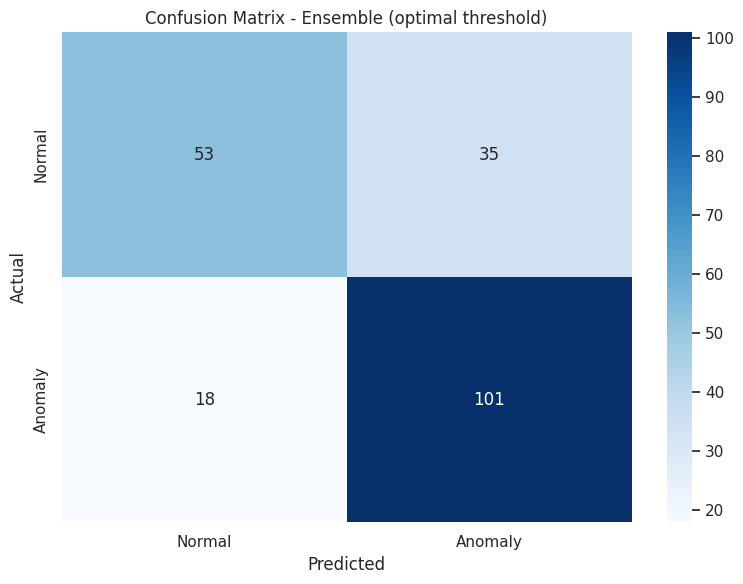

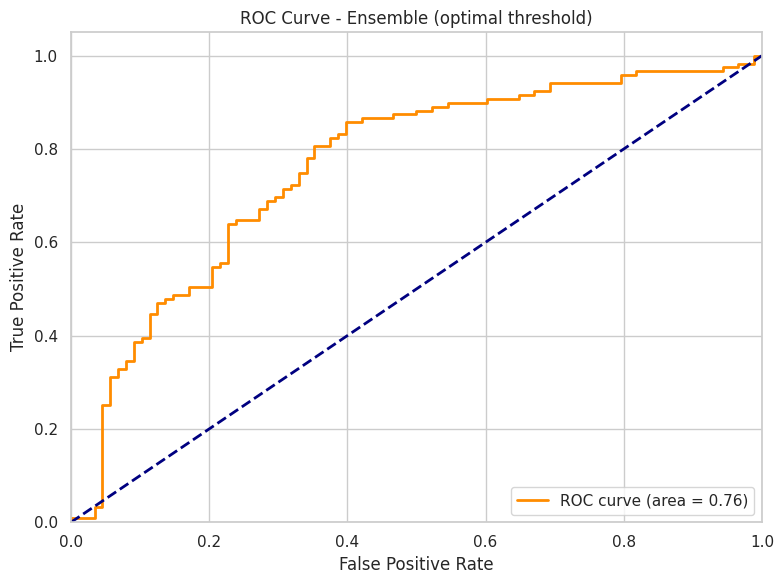

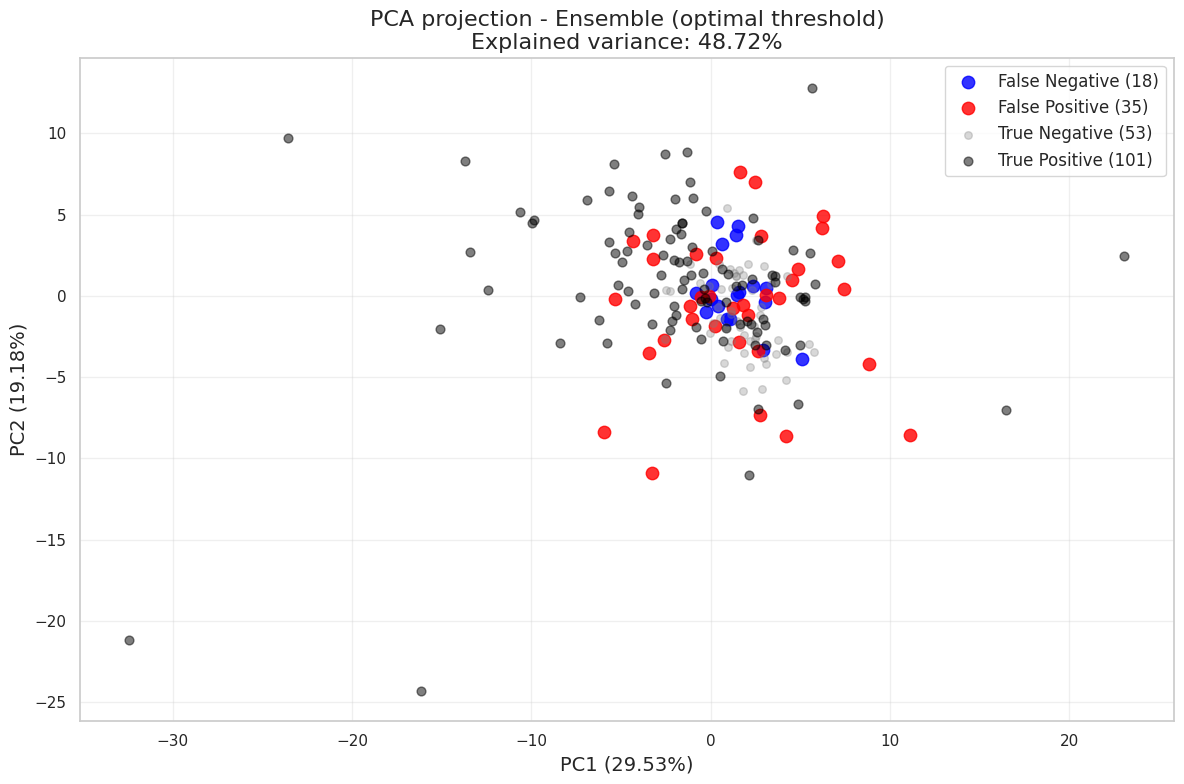

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


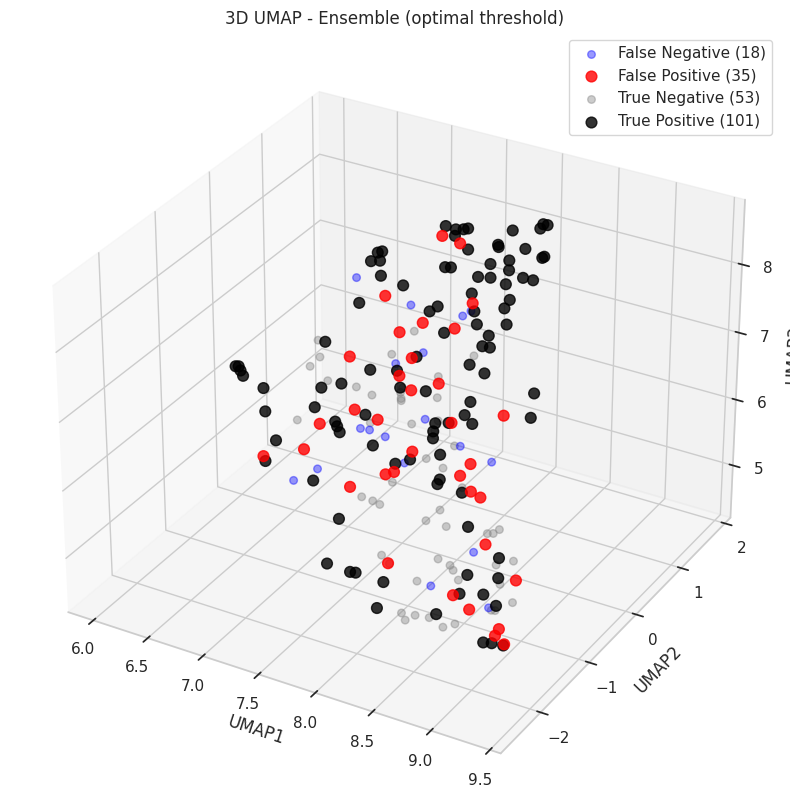

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.preprocessing import MinMaxScaler

# 1. Get individual model scores
autoencoder_scores = test_errors
xgb_scores = y_scores
lof_scores = -lof_score_final

# 2. Normalize all scores to [0, 1] for ensemble
scaler = MinMaxScaler()
ensemble_input = np.vstack([
    autoencoder_scores,
    xgb_scores,
    lof_scores
]).T

ensemble_scores = scaler.fit_transform(ensemble_input)
average_score = ensemble_scores.mean(axis=1)

# ────────────────────────────────────────────────
# 3.1 Ensemble with threshold = 0.5 (default)
ensemble_pred_05 = (average_score > 0.5).astype(int)
print("\n--- Ensemble with threshold = 0.5 ---")
ensemble_metrics_05 = evaluate_model(y_test, ensemble_pred_05, average_score, "Ensemble (threshold = 0.5)")
visualize_pca(X_test_scaled, y_test, ensemble_pred_05, "Ensemble (threshold = 0.5)")
visualize_umap_3d(X_test_scaled, y_test, ensemble_pred_05, "Ensemble (threshold = 0.5)")
results.append(("Ensemble (threshold = 0.5)", *ensemble_metrics_05))

# ────────────────────────────────────────────────
# 3.2 Ensemble with optimal threshold from ROC
fpr, tpr, thresholds = roc_curve(y_test, average_score)
youden_j = tpr - fpr
best_threshold = thresholds[np.argmax(youden_j)]
print(f"\nBest threshold from ROC (Youden's J): {best_threshold:.4f}")

ensemble_pred_opt = (average_score > best_threshold).astype(int)
print("\n--- Ensemble with optimal threshold ---")
ensemble_metrics_opt = evaluate_model(y_test, ensemble_pred_opt, average_score, "Ensemble (optimal threshold)")
visualize_pca(X_test_scaled, y_test, ensemble_pred_opt, "Ensemble (optimal threshold)")
visualize_umap_3d(X_test_scaled, y_test, ensemble_pred_opt, "Ensemble (optimal threshold)")
results.append(("Ensemble (optimal threshold)", *ensemble_metrics_opt))


### Ensemble Model Summary (AE + XGBoost + LOF)

This ensemble combines three complementary approaches to anomaly detection:

* **Autoencoder (AE)** – a neural network that captures data structure via reconstruction error (unsupervised),
* **Local Outlier Factor (LOF)** – a density-based unsupervised method,
* **XGBoost** – a supervised learning model trained on labeled anomalies.

By averaging their normalized scores, the ensemble leverages the strengths of neural, statistical, and supervised methods, improving robustness and accuracy across diverse anomaly types.
